In [14]:
fig_index = 48

# Import Modules

In [2]:
import os, sys, math, random, ast, swifter, re, warnings, csv, json, pickle, matplotlib
import numpy as np
import pandas as pd
import datetime as dt
import portion as P
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pprint import pprint
from collections import namedtuple

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

# DataLoader

In [3]:
def data_loader(
    mode='sr',
    sel_dates=[],  exc_dates=[],
    sel_exps=[],   exc_exps=[],
    sel_routes=[], exc_routes=[], query_dates=False, show_all=False):
    # Specify root directory
    root_dir = '/Users/jackbedford/Desktop/MOXA/Code/data'
    dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s != 'backup']
    
    if show_all:
        # Collect all experiment date_dirs
        date_dirs = [os.path.join(root_dir, s) for s in dates]
        
        for date, date_dir in zip(dates, date_dirs):
            # Specify path to your JSON file
            date = os.path.basename(date_dir)
            json_filepath = os.path.join(date_dir, f'{date}.json')
            # Read the JSON file and load its contents into a dictionary
            with open(json_filepath, 'r', encoding='utf-8') as json_file:
                my_dict = json.load(json_file)
            # If the JSON file is empty, then continue
            if not my_dict:
                continue
            # Show all the datasets in this database
            print(date, len(my_dict))
            for exp, item in my_dict.items():
                print({exp: item})
    
    if query_dates:     
        return dates

    # Collect Experiments
    date_dirs = [os.path.join(root_dir, s) for s in sel_dates if s not in exc_dates]
    exps_dict = {}
    
    for date_dir in date_dirs:
        date = os.path.basename(date_dir)
        # Specify the path to your JSON file
        json_filepath = os.path.join(date_dir, f'{date}.json')
        # Read the JSON file and load its contents into a dictionary
        with open(json_filepath, 'r', encoding='utf-8') as json_file:
            my_dict = json.load(json_file)
        # If the JSON file is empty, then continue
        if not my_dict:
            continue
        # Filter out useless datasets
        for i, (exp, item) in enumerate(my_dict.items()):
            if len(sel_exps) != 0 and exp not in sel_exps:
                continue
            if len(exc_exps) != 0 and exp in exc_exps:
                continue
            if len(sel_routes) != 0 and item['route'] not in sel_routes:
                continue
            if len(exc_routes) != 0 and item['route'] in sel_routes:
                continue
            try:
                exps_dict[date] = {**exps_dict[date], **{exp: item}}
            except:
                exps_dict[date] = {exp: item}
                
    for date, exps in exps_dict.items():
        print(date, len(exps))
        for exp_name, exp in exps.items():
            print({exp_name: exp})
    
    
    filepaths = []
    if mode == 'sr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev in devices:
                        data_dir = os.path.join(exp_dir, dev, trip, 'data')
                        filepaths.append([
                            os.path.join(data_dir, 'handover_info_log.csv'),
                            os.path.join(data_dir, 'udp_dnlk_loss_latency.csv'),
                            os.path.join(data_dir, 'udp_uplk_loss_latency.csv')
                            ])
    elif mode == 'dr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                combos = list(it.combinations(devices, 2))
                for trip in trips:
                    for dev1, dev2 in combos:
                        data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                        data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                        filepaths.append((
                            [os.path.join(data_dir1, 'handover_info_log.csv'), os.path.join(data_dir1, 'udp_dnlk_loss_latency.csv'), os.path.join(data_dir1, 'udp_uplk_loss_latency.csv')],
                            [os.path.join(data_dir2, 'handover_info_log.csv'), os.path.join(data_dir2, 'udp_dnlk_loss_latency.csv'), os.path.join(data_dir2, 'udp_uplk_loss_latency.csv')],
                            ))
    
    return filepaths

In [4]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['BR']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
pprint(filepaths)

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'skip': False, 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'ue': 'Phone', 'sync': None, 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園',

眾數: 0
中位數: 0.7507865
平均值: 3.9050327185792346
標準差: 10.932154377594989
最大值: 142.95689
最小值: 0.092357


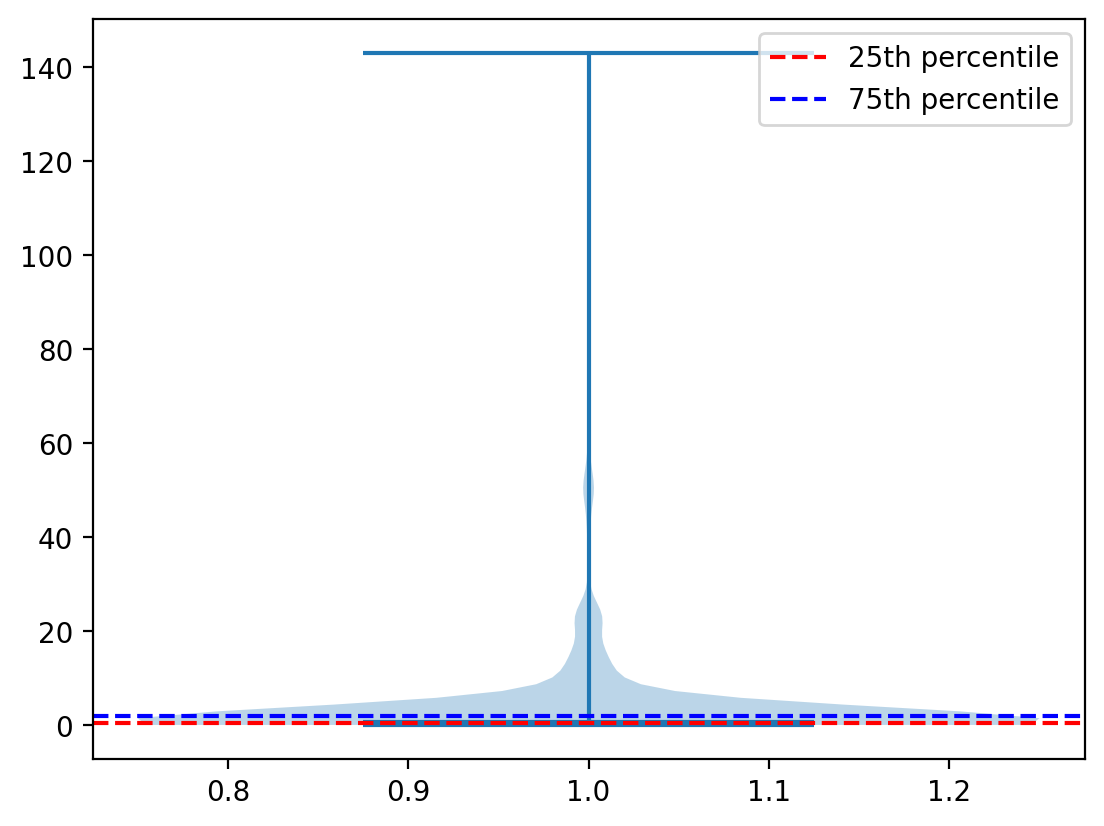

In [5]:
df = pd.read_csv(filepaths[0][0], parse_dates=['start', 'end'])[['type', 'start', 'end']]
df['next_start'] = df['start'].shift(-1)
df['period'] = (df['next_start'] - df['end']).dt.total_seconds()
data = df['period'].to_list()[:-1]

# 计算眾數
mode = np.bincount(data).argmax()
# 计算中位數
median = np.median(data)
# 计算平均值
mean = np.mean(data)
# 计算標準差
std_deviation = np.std(data)
# 计算最大值和最小值
maximum = np.max(data)
minimum = np.min(data)

# 输出结果
print("眾數:", mode)
print("中位數:", median)
print("平均值:", mean)
print("標準差:", std_deviation)
print("最大值:", maximum)
print("最小值:", minimum)

# Calculate the 25th and 75th percentiles
q25, q75 = np.percentile(data, [25, 75])
# Create the violin plot
plt.violinplot(data, showmeans=False, showmedians=True)
# Add lines for the 25th and 75th percentiles
plt.axhline(y=q25, color='r', linestyle='--', label='25th percentile')
plt.axhline(y=q75, color='b', linestyle='--', label='75th percentile')

# Add legend
plt.legend()
# Show the plot
plt.show()

# Basic Functions

In [6]:
# ----------------------------------------------------------------------------------------------
# set_data
# ----------------------------------------------------------------------------------------------

def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

# ----------------------------------------------------------------------------------------------
# parse_mi_ho
# ----------------------------------------------------------------------------------------------

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ----------------------------------------------------------------------------------------------
# mi_parse_handover
# ----------------------------------------------------------------------------------------------

def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    # table[['eNB_ID', 'next_eNB_ID',]] = table[['eNB_ID', 'next_eNB_ID']].astype('Int64')
    table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']] = \
        table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']].astype('Int64')
    
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2[col].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

# ----------------------------------------------------------------------------------------------
# is_disjoint, interp
# ----------------------------------------------------------------------------------------------

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def interp(x, y, ratio):
    """
    Interpolation (線性內插法)

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

# Evaluation Auxiliary Functions

In [7]:
def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(coef_table, x_list, type, center=0):
    _coef = list(coef_table.loc[type])
    
    if center != 0:
        x_list = [x - center for x in x_list]
        
    lower_bd = _coef[2]
    upper_bd = _coef[3]
    coef = _coef[5:]
    p = np.poly1d(coef)
    
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

def generate_random_boolean(probability_true):
    return random.random() < probability_true

# Profiling Functions

In [18]:
def setup_profile(df, df_ho, mode='dl', mets='lost', sp_col=None, scope=None, ts_col='Timestamp'):
    df_origin = df.copy()
    
    def setup_profile_instance(df, tag, start, intv, ts_col='Timestamp', w_size=0.01,
                           mode='dl', mets='lost'):
        
        # Relative window from timestamp
        df_plot = df[(df[ts_col] >= intv.lower) & (df[ts_col] < intv.upper)].copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - start).dt.total_seconds()
        
        # 四捨五入
        df_plot['cat_id'] = ((df_plot['rel_time'] + w_size / 2) // w_size) * w_size
        
        if mets == 'lost':
            # Calculate PLR
            ts_group = df_plot.groupby(['cat_id'])
            table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
            table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
            table['PLR'] = table['PLR'] * 100
        elif mets == 'excl':
            # Calculate ELR
            df_plot['excl_new'] = df_plot['excl'] & ~df_plot['lost']
            ts_group = df_plot.groupby(['cat_id'])
            table = ts_group['excl_new'].agg(['count','sum','mean']).copy().reset_index()
            table = table.rename(columns={'count':'tx_count', 'sum':'excl', 'mean':'ELR'})
            table['ELR'] = table['ELR'] * 100
        
        return table, intv

    # Initialize
    A = {tag: {'tables': [], 'intrs': [], 'triggered': []} for tag in [*scope.keys(), 'stable']}
    stable_intv = P.open(pd.Timestamp.min, pd.Timestamp.max)
    stable_pkt = 0
    stable_miss = 0
    stable_miss_rate = 0

    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row[sp_col]  # specific column name
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        
        # Set left/right bounds to avoid event overlapping with each other
        if prior_row is not None:
            if pd.notna(prior_row['end']):
                left = prior_row['end'] + (start - prior_row['end']) / 2
            else:
                left = prior_row['start'] + (start - prior_row['start']) / 2
        else:
            left = pd.Timestamp.min
        if post_row is not None:
            if pd.notna(end):
                right = end + (post_row['start'] - end) / 2
            else:
                right = start + (post_row['start'] - start) / 2
        else:
            right = pd.Timestamp.max
        
        # Centered at start timestamp of each handover event
        intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
        
        # Consider the stable duration before an event starts
        df_stable = df[df[ts_col] < intv.lower].copy()
        df_stable['Timestamp_sec'] = df_stable['Timestamp'].dt.floor('S')
        if not df_stable.empty:
            unique_timestamps = df_stable['Timestamp_sec'].unique()
            df_tmp = df_stable.copy()
            for ts in unique_timestamps:
                _start = ts + pd.Timedelta(seconds=0.5)
                _stable_intv = P.closed(ts, min(ts + pd.Timedelta(seconds=1), intv.lower))
                # Setup a stable profile instance
                table, _ = setup_profile_instance(df_tmp, tag='stable', start=_start, mode=mode, mets=mets, intv=_stable_intv)
                A['stable']['intrs'].append(1)
                if table['lost'].sum() > 0:
                    A['stable']['tables'].append(table)  # profile table instance
                    A['stable']['triggered'].append(1) # trigger loss
                # Update dataframe to accelerate
                df_tmp = df_tmp[df_tmp[ts_col] >= ts + pd.Timedelta(seconds=1)]
        
        # Setup a profile instance
        table, _ = setup_profile_instance(df, tag=tag, start=start, mode=mode, mets=mets, intv=intv)
        # print(tag)
        # print(table)
        
        # Update dataframe to accelerate the speed
        df = df[df[ts_col] >= intv.upper].copy()
        
        A[tag]['intrs'].append(intr)  # handover interruption time
        if table['lost'].sum() > 0:
            A[tag]['tables'].append(table)  # profile table instance
            A[tag]['triggered'].append(1) # trigger loss
        
        # Update stable interval
        stable_intv = stable_intv - intv
    
    # Consider the stable duration after the last event ends
    df_stable = df.copy()
    # df_stable = df[df[ts_col] >= intv.upper].copy()
    df_stable['Timestamp_sec'] = df_stable['Timestamp'].dt.floor('S')
    if not df_stable.empty:
        unique_timestamps = df_stable['Timestamp_sec'].unique()
        df_tmp = df_stable.copy()
        for ts in unique_timestamps:
            _start = ts + pd.Timedelta(seconds=0.5)
            _stable_intv = P.closed(ts, ts + pd.Timedelta(seconds=1))
            # Setup a stable profile instance
            table, _ = setup_profile_instance(df_tmp, tag='stable', start=_start, mode=mode, mets=mets, intv=_stable_intv)
            A['stable']['intrs'].append(1)
            if table['lost'].sum() > 0:
                A['stable']['tables'].append(table)  # profile table instance
                A['stable']['triggered'].append(1) # trigger loss
            # Update dataframe to accelerate
            df_tmp = df_tmp[df_tmp[ts_col] >= ts + pd.Timedelta(seconds=1)]

    # # Count lost and transferred packets under stable state
    # for intv in stable_intv:
    #     lower = intv.lower; upper = intv.upper
    #     df_tmp = df_origin[(df_origin[ts_col] > lower) & (df_origin[ts_col] <= upper)].copy().reset_index(drop=True)
        
    #     stable_pkt += len(df_tmp)
    #     if mets == 'lost':
    #         stable_miss += sum(df_tmp['lost'])
    #     elif mets == 'excl':
    #         stable_miss += sum(df_tmp['excl'] & ~df_tmp['lost'])
    
    # stable_miss_rate = round(stable_miss / (stable_pkt + 1e-9) * 100, 3)
    
    # # Calculate stable duration, proportion
    # stable_duration = 0
    # stable_intv = stable_intv & P.closed(df.iloc[0]['xmit_time'], df.iloc[-1]['xmit_time'])
    # for intv in stable_intv:
    #     stable_duration += (intv.upper - intv.lower).total_seconds()
        
    # total_duration = (df_origin.iloc[-1]['xmit_time'] - df_origin.iloc[0]['xmit_time']).total_seconds()
    # stable_proportion = round(stable_duration / (total_duration + 1e-9) * 100, 3)
    
    # return A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion
    return A, stable_miss, stable_pkt, stable_miss_rate, 0, 0, 0

In [19]:
def merge_profile(tables, intrs, mets='lost'):
    
    intr = np.mean(intrs)
    if mets == 'lost':
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
    elif mets == 'excl':
        table = pd.DataFrame(columns=['cat_id','tx_count','excl','ELR'])
        table['excl'] = table['excl'].astype('Int32')
        table['ELR'] = table['ELR'].astype('float32')
    
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        
        if mets == 'lost':
            table['lost'] = table['lost_x'] + table['lost_y']
            table['PLR'] = 0
            table = table[['cat_id','tx_count','lost','PLR']]
        elif mets == 'excl':
            table['excl'] = table['excl_x'] + table['excl_y']
            table['ELR'] = 0
            table = table[['cat_id','tx_count','excl','ELR']]
    
    if mets == 'lost':    
        table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    elif mets == 'excl':
        table['ELR'] = table['excl'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','excl','ELR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    
    return table, intr

In [20]:
def data_aligner(df, df_ho):
    if df_ho.empty:
        start = pd.Timestamp.max()
        end = pd.Timestamp.min()
    else:
        start = df_ho.iloc[0]['start'] - pd.Timedelta(seconds=10)
        end = df_ho.iloc[-1]['start'] + pd.Timedelta(seconds=10)
    print(start, end)
    df = df[(df['Timestamp'] >= start) & (df['Timestamp'] < end)]
    return df

def build_all_profile(filepaths, scope, metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl'], sp_col='type'):

    D = {mm: {tag: {'tables': [], 'intrs': [], 'count': [], 'triggered': []} for tag in [*scope[mm].keys(), 'stable']} for mm in metrics}
    E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in metrics}

    N = len(filepaths)
    for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
        
        # if i > 0:     
        #     break
        
        print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
        df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
        
        if df_ho.empty:
            continue
        
        df_dl = data_aligner(set_data(pd.read_csv(dl_filepath)), df_ho)
        df_ul = data_aligner(set_data(pd.read_csv(ul_filepath)), df_ho)
        
        for mm in metrics:
            mode = mm[:2]
            mets = mm[-4:]
            if mode == 'dl':
                df = df_dl.copy()
            else:
                df = df_ul.copy()
            
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion = \
                setup_profile(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope[f'{mode}_{mets}'])
            
            # Merge instances for each event's profile in a trace
            for tag in [*scope[f'{mode}_{mets}'].keys(), 'stable']:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['intrs']))
                D[f'{mode}_{mets}'][tag]['triggered'].append(len(A[tag]['triggered']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
                
    return D, E, scope

In [21]:
def approx_scope(table, mets='lost', evt_type='RLF', stable_miss_rate=0):
    table['new'] = (table[mets] - table['tx_count'] * stable_miss_rate / 1e3).round()
    table_tmp = table[table['new'] > 0]
    
    if len(table_tmp) == 0:
        return 0
    
    lower = min(math.floor(table.iloc[0]['cat_id'] * 10), -1)
    upper = max(math.ceil(table.iloc[-1]['cat_id'] * 10), 1)

    # total = sum(table_tmp[mets])
    total = sum(table_tmp['new'])
    if evt_type == 'RLF':
        thr = round(total * 0.9973)
    elif evt_type == 'HO':
        thr = round(total * 0.9973)
        # thr = round(total * 0.9876)
        # thr = round(total * 0.9545)
        # thr = round(total * 0.8664)
        # thr = round(total * 0.6827)
    else:
        print(f'No category: {evt_type}!!')
        raise

    scope_candidate = []
    scope_duration = []
    for i in range(lower, 0):
        for j in range(1, upper+1):
            k = i/10; l = j/10
            _table_tmp = table_tmp[(table_tmp['cat_id'] >= k) & (table_tmp['cat_id'] < l)]
            # miss = sum(_table_tmp[mets])
            miss = sum(_table_tmp['new'])
            # print(miss, thr)
            if miss >= thr:
                scope_candidate.append((k, l))
                scope_duration.append(l-k)
    
    if len(scope_duration) == 0:
        return 0
    
    min_value = min(scope_duration)
    min_scope = [scp for scp, value in zip(scope_candidate, scope_duration) if value == min_value]
    print(min_scope)

    return min_scope[0]

# Setup Profiles

In [22]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['A']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
pprint(filepaths)

# sampled_filepaths = filepaths[-9:]
# filepaths = filepaths[:-9]

# filepaths = filepaths[0:1]
filepaths = filepaths[fig_index:fig_index+1]

2023-10-26 1
{'UDP_Bandlock_9S_Phone_Airport': {'route': 'A', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '台北車站', '機場第二航廈', '13:30', '直達車'], [2, '機場第二航廈', '台北車站', '14:25', '直達車']], 'stations': ['台北車站', '三重', '新北產業園區', '新莊副都心', '泰山', '泰山貴和', '體育大學', '長庚醫院', '林口', '山鼻', '坑口', '機場第一航廈', '機場第二航廈'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-11-01 1
{'UDP_Bandlock_9S_Phone_Airport': {'route': 'A', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '台北車站', '機場第二航廈', '14:52', '普通車'], [2, '機場第二航廈', '台北車站', '16:04', '普通車']], 'stations': ['台北車站', '三重', '新北產業園區', '新莊副都心',

In [23]:
filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv']]

## Stage 1: fix 5, 10 seconds

In [24]:
lookup = {
        'LTEH': 'HO',
        'ENBH': 'HO',
        'MCGH': 'HO',
        'MNBH': 'HO',
        'SCGA': 'HO',
        'SCGM': 'HO',
        'SCGR-I': 'HO',
        'SCGR-II': 'HO',
        'SCGC-I': 'HO',
        'SCGC-II': 'HO',
        'MCGF': 'RLF',
        'NASR': 'RLF',
        'SCGF': 'RLF',
    }
# metrics=['dl_lost']
# Category_scope = {
#     mets: {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)} for mets in metrics
# }
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in metrics }

# # df_ho = pd.read_csv(filepaths[0][0], parse_dates=['start', 'end'])
# # df = set_data(pd.read_csv(filepaths[0][1]))

# # A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion = \
# #     setup_profile(df=df, df_ho=df_ho, scope=scope[f'dl_lost'], sp_col='type')

# HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, scope=scope, metrics=metrics)
# print('****************************************************************')


# ****************************************************************
metrics=['dl_lost']

Category_scope = {
    mets: {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)} for mets in metrics
}

# columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
# sp_col = 'type'

scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in metrics }

# pprint(scope, sort_dicts=False)

HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, scope=scope, metrics=metrics)
print('****************************************************************')

0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
2023-11-02 17:56:02.787022 2023-11-02 18:35:25.239424
2023-11-02 17:56:02.787022 2023-11-02 18:35:25.239424
Overlapping event occurs!!
109 2023-11-02 18:12:32.165880 2023-11-02 18:12:32.635233 MCGH nan
110 2023-11-02 18:12:32.460537 2023-11-02 18:12:32.548924 MCGF handoverFailure (1)
Overlapping event occurs!!
158 2023-11-02 18:18:45.069357 2023-11-02 18:18:45.966701 MCGH nan
159 2023-11-02 18:18:45.827525 2023-11-02 18:18:45.914665 MCGF handoverFailure (1)
****************************************************************


LTEH
Number of Event: 6
Number of Triggered: 2
Average Duration: 0.025665000000000004 seconds
[(-0.5, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.1) 15.468


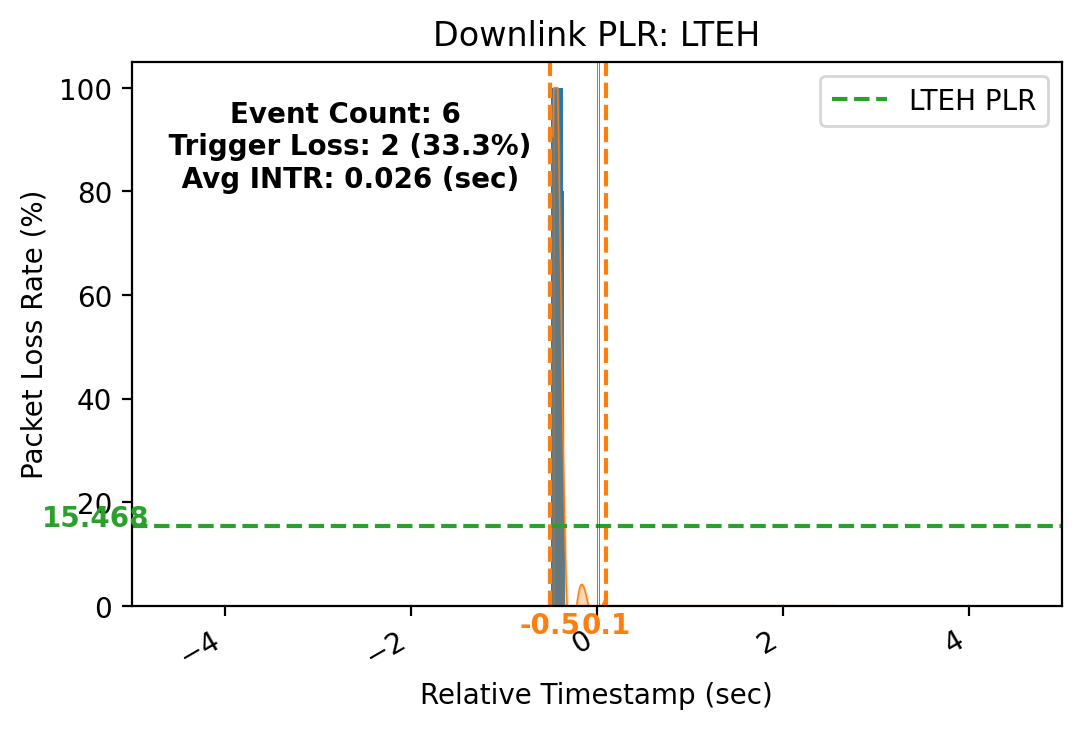

ENBH
Number of Event: 11
Number of Triggered: 1
Average Duration: 0.02198363636363637 seconds
[(-0.5, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.1) 24.303


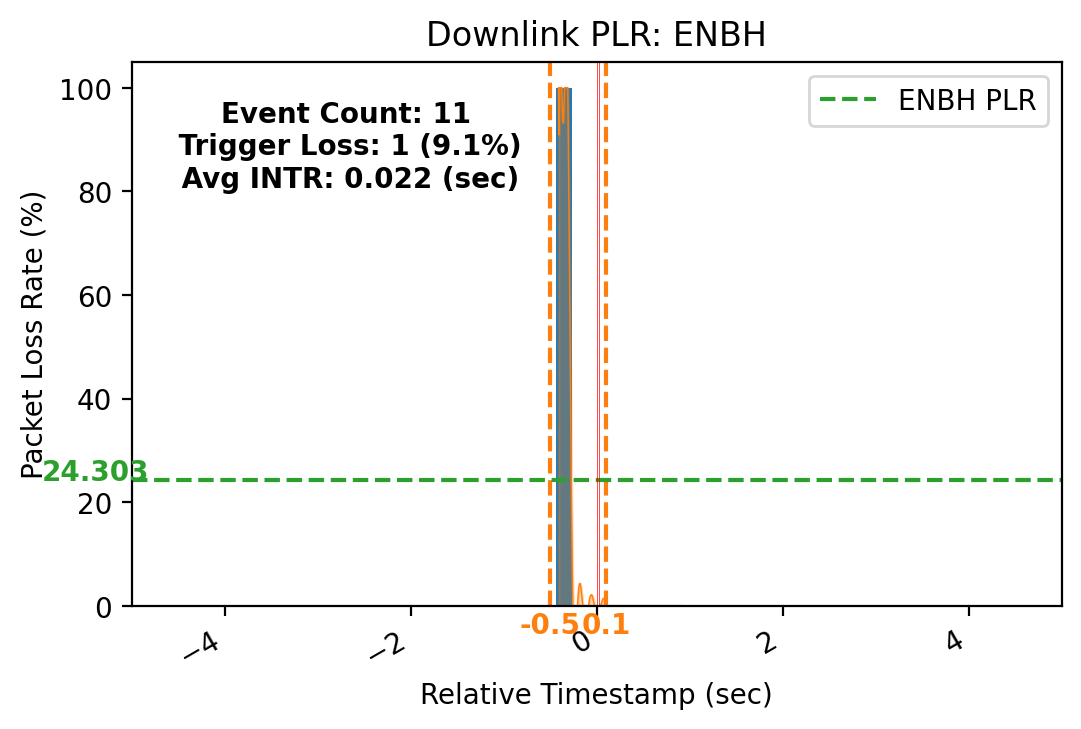

MCGH
Number of Event: 44
Number of Triggered: 16
Average Duration: 0.018170431818181818 seconds
[(-1.5, 0.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.5, 0.8) 7.507


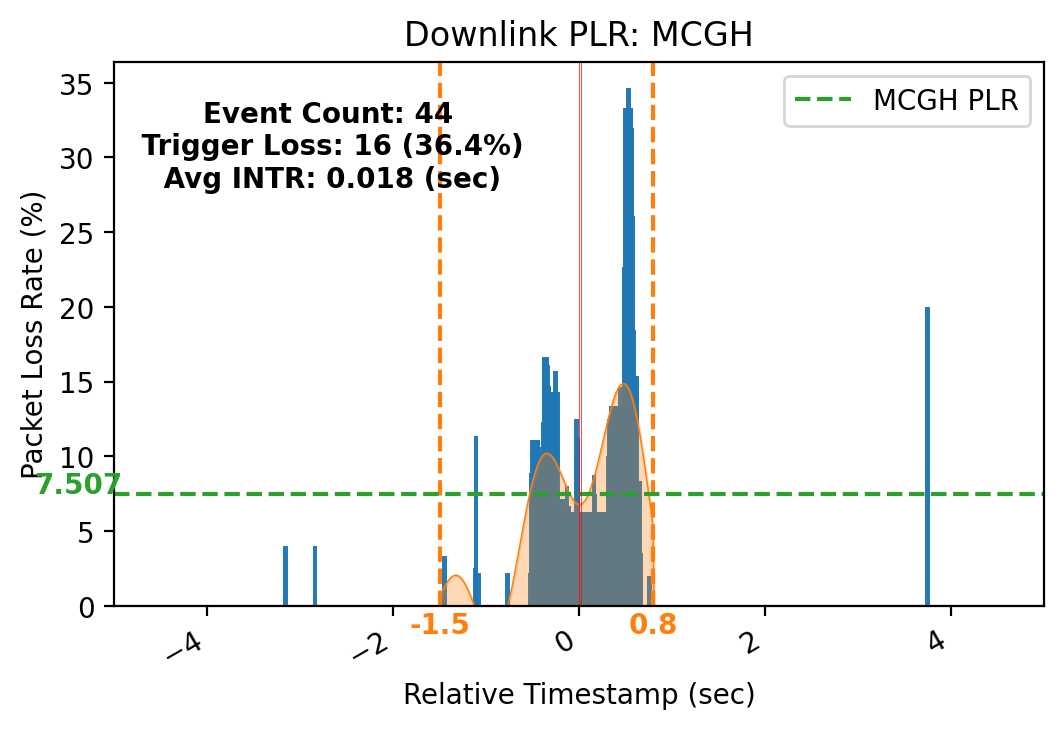

MNBH
Number of Event: 107
Number of Triggered: 38
Average Duration: 0.01884654205607476 seconds
[(-1.2, 4.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.2, 4.5) 8.848


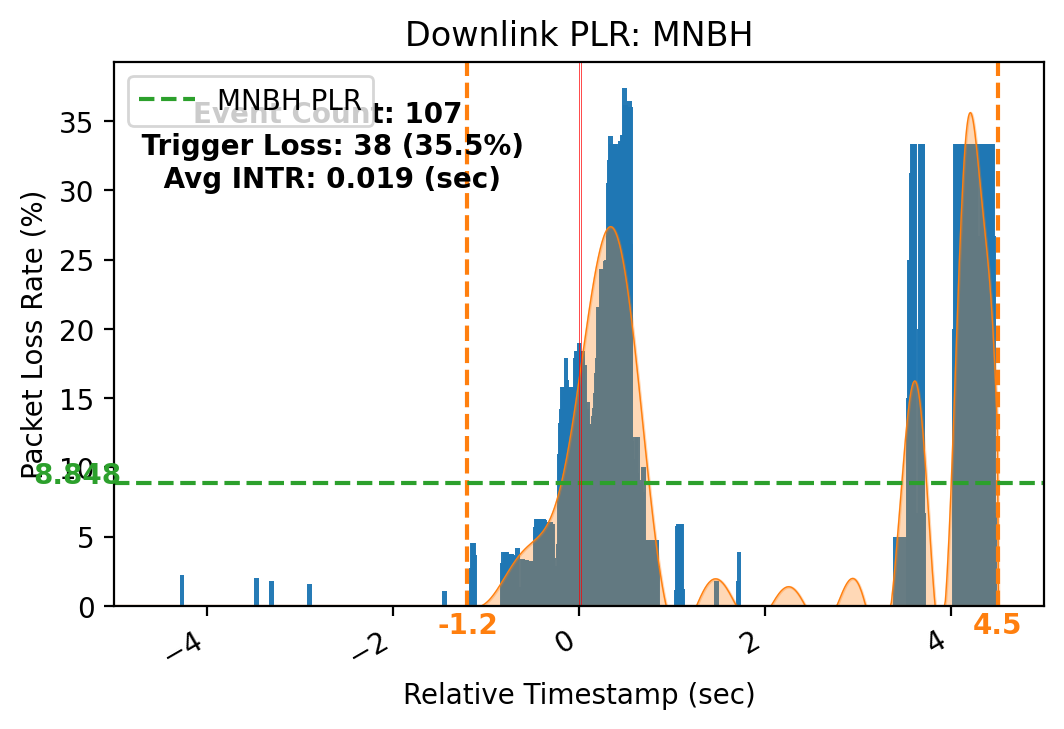

SCGA
Number of Event: 11
Number of Triggered: 1
Average Duration: 0.03806263636363636 seconds
[(-5.0, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-5.0, 0.1) 59.027


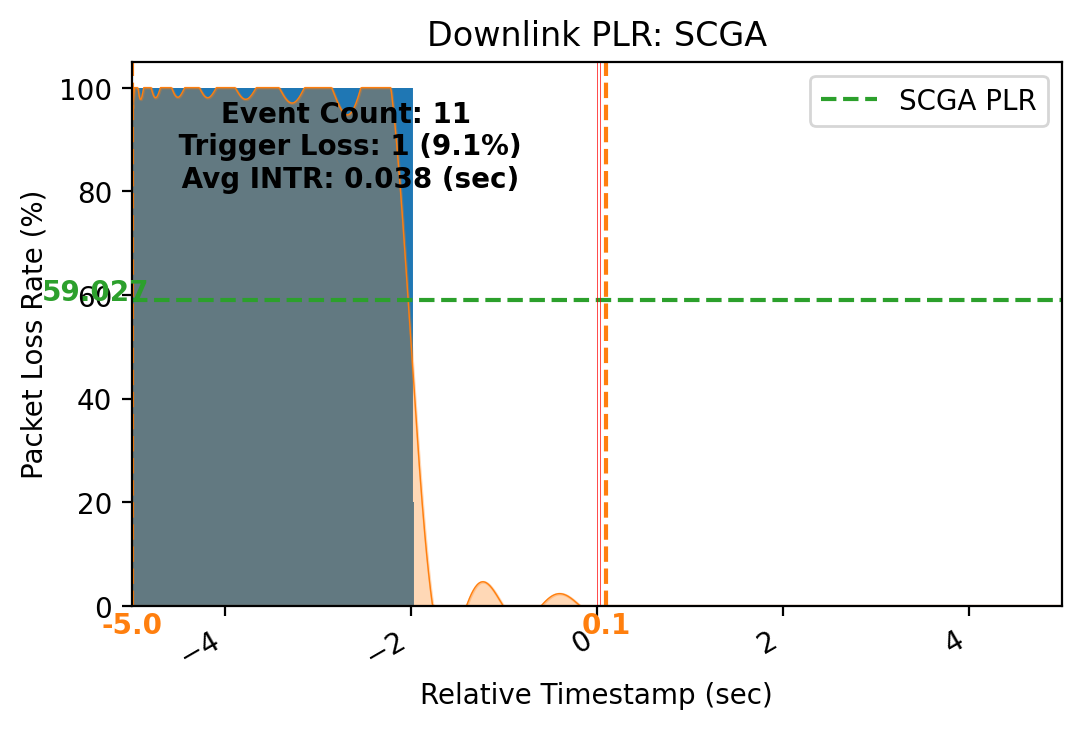

SCGM
Number of Event: 113
Number of Triggered: 51
Average Duration: 0.018403513274336286 seconds
[(-4.9, 2.9)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.9, 2.9) 2.085


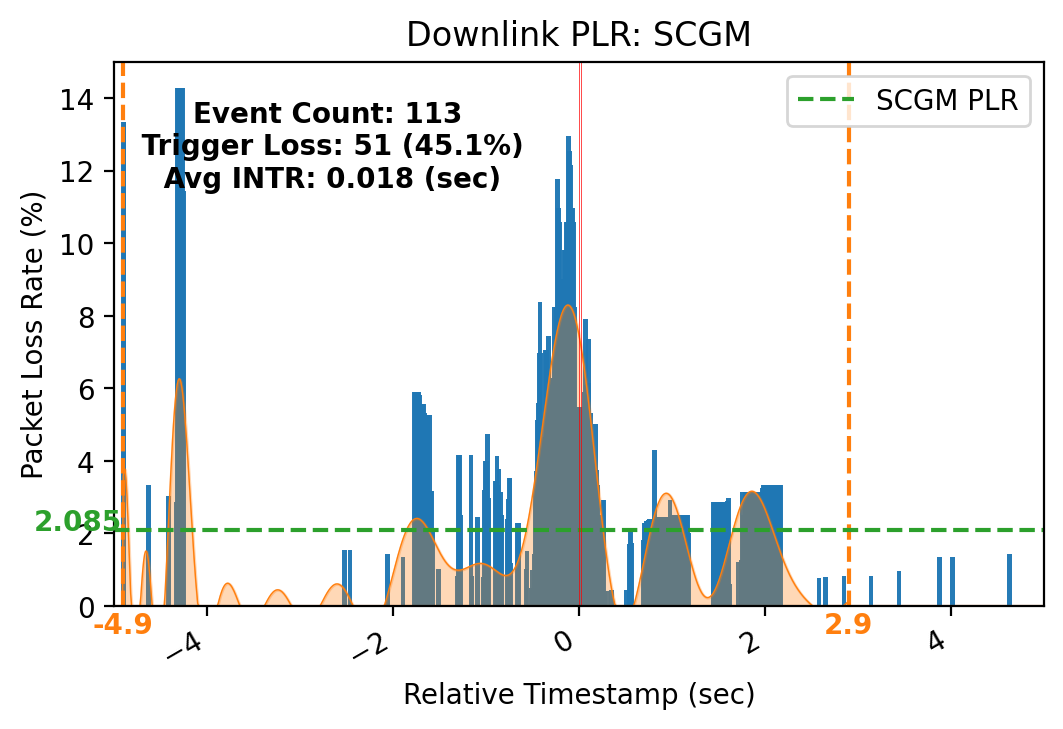

SCGR-II
Number of Event: 3
Number of Triggered: 1
Average Duration: 0.04248266666666667 seconds
[(-0.1, 0.2)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 0.2) 0.84


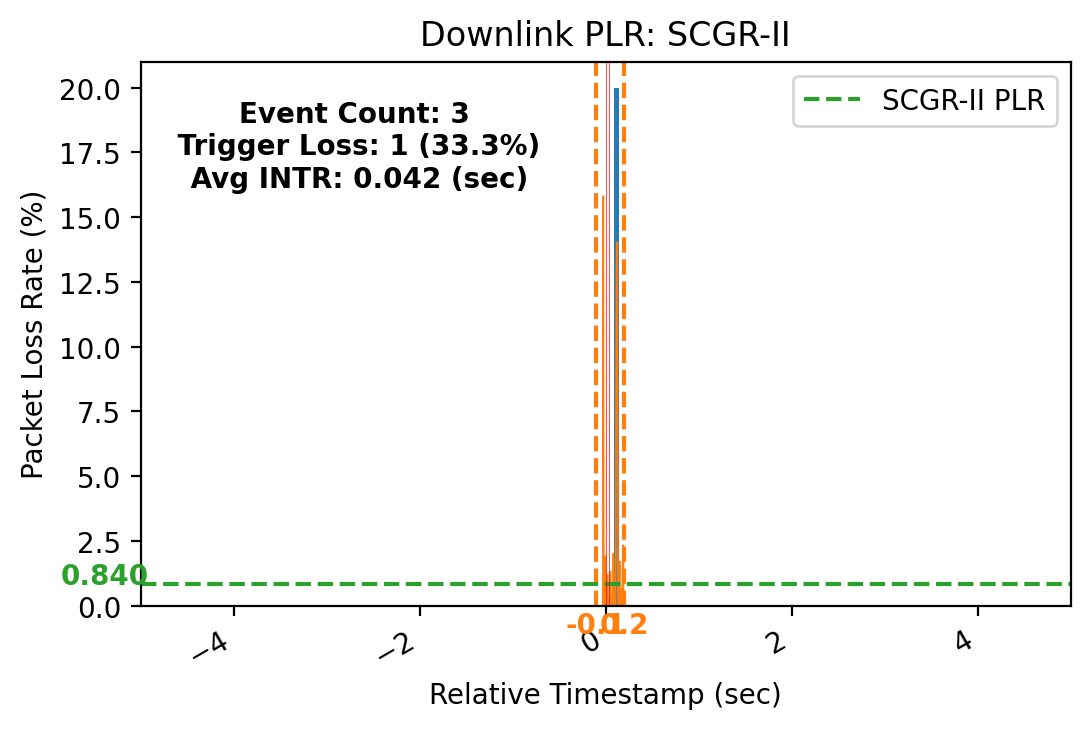

SCGC-I
Number of Event: 6
Number of Triggered: 1
Average Duration: 0.38637916666666666 seconds
[(-0.2, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.2, 0.1) 30.0


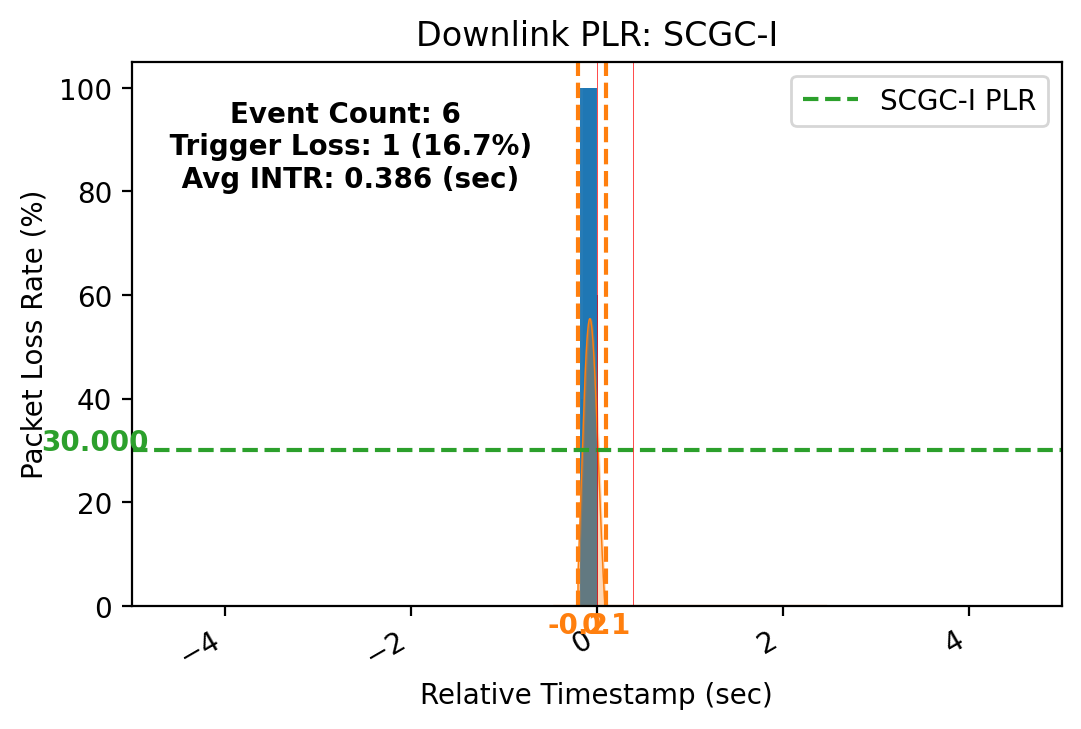

SCGC-II
Number of Event: 6
Number of Triggered: 2
Average Duration: 0.3367286666666667 seconds
[(-4.6, 0.4)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.6, 0.4) 0.217


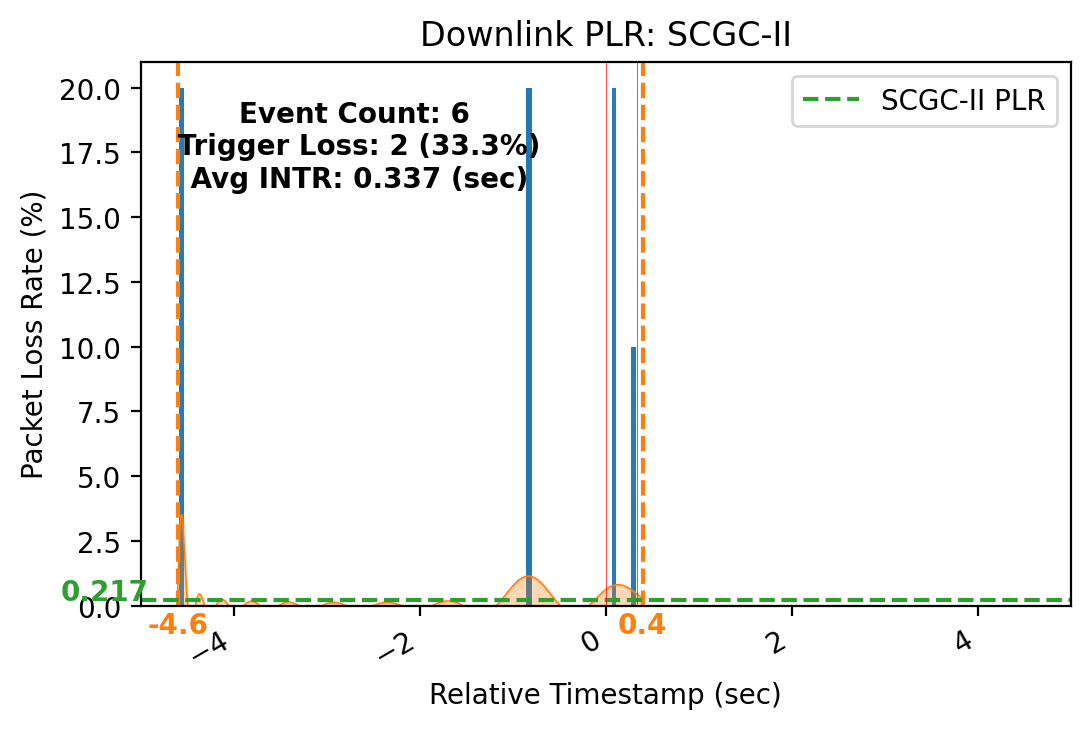

MCGF
Number of Event: 30
Number of Triggered: 30
Average Duration: 0.09295756666666666 seconds
[(-2.1, 6.6)]
Downlink Stable PLR: 0.0
Downlink PLR (-2.1, 6.6) 35.538


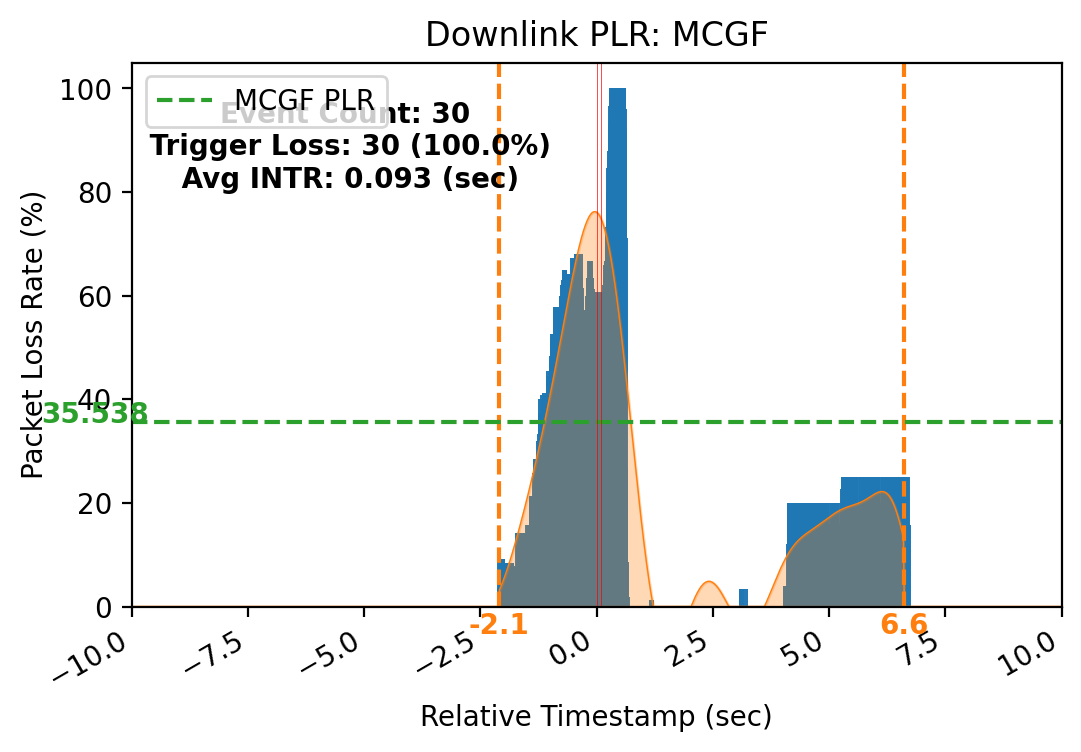

SCGF
Number of Event: 9
Number of Triggered: 2
Average Duration: 0.09646266666666665 seconds
[(-6.4, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-6.4, 0.1) 4.257


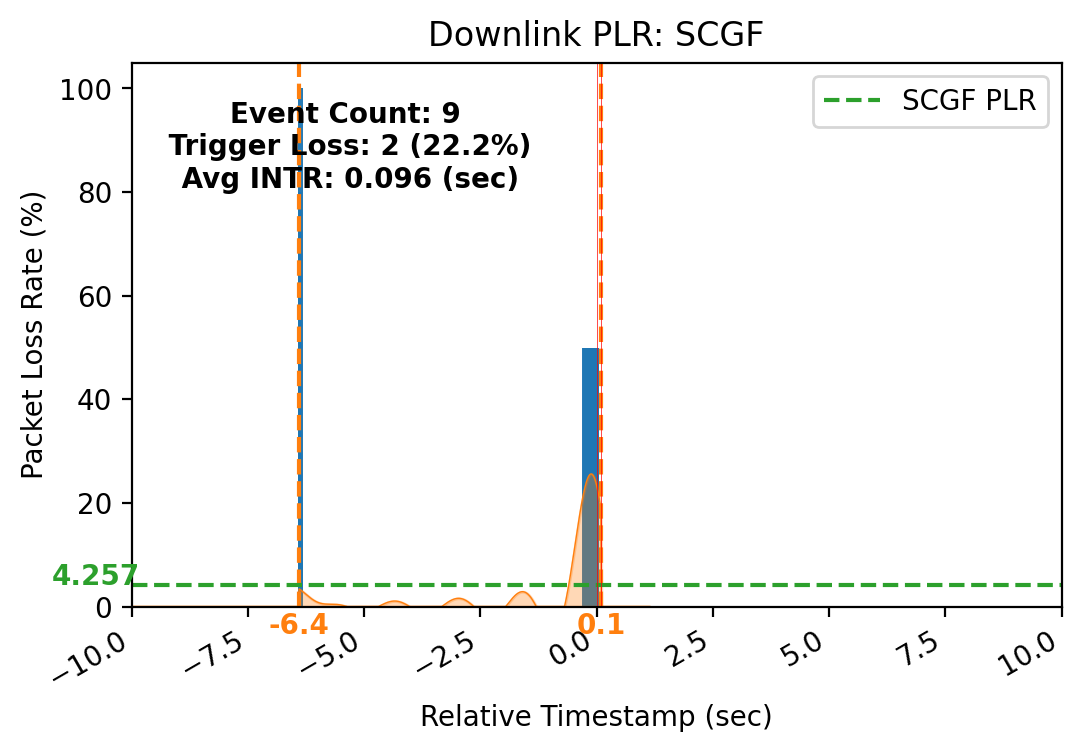

stable
Number of Event: 998
Number of Triggered: 107
Average Duration: 1.0 seconds
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.5) 91.144


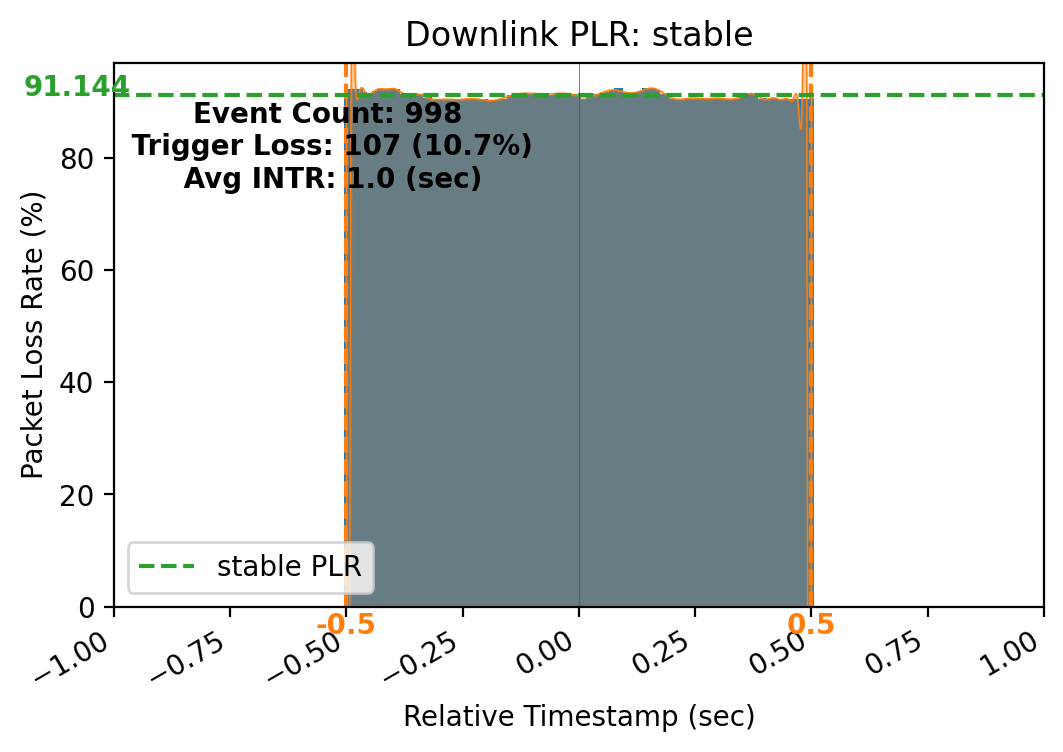

{'dl_lost': {'LTEH': (-0.5, 0.1),
             'ENBH': (-0.5, 0.1),
             'MCGH': (-1.5, 0.8),
             'MNBH': (-1.2, 4.5),
             'SCGA': (-5.0, 0.1),
             'SCGM': (-4.9, 2.9),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-0.1, 0.2),
             'SCGC-I': (-0.2, 0.1),
             'SCGC-II': (-4.6, 0.4),
             'MCGF': (-2.1, 6.6),
             'NASR': (-10.0, 10.0),
             'SCGF': (-6.4, 0.1),
             'stable': (-0.5, 0.5)}}


In [25]:
# # de-comment while not running the first time
# D = HOType_D.copy()
# E = HOType_E.copy()
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# # *******************************************************************************************
D = HOType_D.copy()
E = HOType_E.copy()
scope = Initial_scope.copy()
# metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']
metrics=['dl_lost']

coef_tpl = pd.DataFrame(columns=['count', 'triggered', 'PLR/ELR', 'lower_bd', 'upper_bd', 'intr', *list(range(71))])
for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']:
    coef_tpl.loc[tag] = [0, 0, 0, -5, 5, 0, *np.zeros(71)]
for tag in ['MCGF', 'NASR', 'SCGF']:
    coef_tpl.loc[tag] = [0, 0, 0, -10, 10, 0, *np.zeros(71)]
coef_tpl.loc['stable'] = ['-', '-', 0, '-', '-', '-', *np.zeros(71)]
    
coef_df = {mets: coef_tpl.copy() for mets in metrics}

# coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

dist_df = {mets: {tag: pd.DataFrame(columns=['cat_id', 'tx_count', 'lost', 'PLR']) for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'MCGF', 'NASR', 'SCGF', 'stable']} for mets in metrics}

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in metrics }

for tag in [*scope[list(scope.keys())[0]].keys(), 'stable']:
    if len(D[list(D.keys())[0]][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
    
    for mm in metrics:
        mode = mm[:2]
        mets = mm[-4:]
        
        if mets == 'lost':
            stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_PLR
        elif mets == 'excl':
            stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_ELR
            
        table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
        
        print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
        print('Number of Triggered:', sum(D[f'{mode}_{mets}'][tag]['triggered']))
        print('Average Duration:', intr, 'seconds')
        
        if tag == 'stable':
            min_scope = (-0.5, 0.5)
        else:
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
        
        if min_scope != 0:
            new_scope[f'{mode}_{mets}'][tag] = min_scope
        
        # def plot_polynomial(scope, mode, mets, ):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # # *********************************************************
        # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
        # new_scope[f'{mode}_{mets}'][tag] = min_scope
        # # *********************************************************
        
        if tag == 'stable':
            left = -0.5; right = 0.5
        else:
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
        bound = math.ceil(max(abs(right), abs(left)))
        left = -bound; right = bound
        ax.set_xlim(left, right)
        
        # width = 0.015 * (right - left)
        width = 0.005 * (right - left)
        if mets == 'lost':
            ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
        elif mets == 'excl':
            ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
            
        ax.set_ylim(0, max(1, ax.get_ylim()[1]))
        bottom, top = ax.get_ylim()

        if min_scope != 0:
            ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
            ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
            ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            
            bleft = min_scope[0]
            bright = min_scope[1]
            
            x = np.asarray(table['cat_id'], dtype=np.float64)
            if mets == 'lost':
                y = np.asarray(table['PLR'], dtype=np.float64)
            elif mets == 'excl':
                y = np.asarray(table['ELR'], dtype=np.float64)
                
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                z = np.polyfit(x, y, 70)
                p = np.poly1d(z)
            xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
            
            coef = p.coefficients
            
            ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
            ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
        
        if mets == 'lost':
            # ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
            # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable PLR:', stable_PLR)
                    print('Downlink PLR', min_scope, PLR)
                elif mode == 'ul':
                    print('Uplink Stable PLR:', stable_PLR)
                    print('Uplink PLR', min_scope, PLR)
                ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        elif mets == 'excl':
            # ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
            # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable ELR:', stable_ELR)
                    print('Downlink ELR', min_scope, ELR)
                elif mode == 'ul':
                    print('Uplink Stable ELR:', stable_ELR)
                    print('Uplink ELR', min_scope, ELR)
                ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                
        count = sum(D[f'{mode}_{mets}'][tag]['count'])
        triggered = sum(D[f'{mode}_{mets}'][tag]['triggered'])
        trigger_rate = sum(D[f'{mode}_{mets}'][tag]['triggered']) / (sum(D[f'{mode}_{mets}'][tag]['count']) + 1e-9) * 100
        intr = round(intr, 3)
        ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Trigger Loss: {triggered} ({round(trigger_rate, 1)}%)\n Avg INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
        
        # ******************************************************************************************************************
        if min_scope != 0:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, PLR, bleft, bright, intr, *list(coef)]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, ELR, bleft, bright, intr, *list(coef)]
            # display(table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)])
            dist_df[f'{mode}_{mets}'][tag] = table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)].reset_index(drop=True).copy()
        else:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            # display(table)
            dist_df[f'{mode}_{mets}'][tag] = table.copy()
        # ******************************************************************************************************************
        
        if mode == 'dl':
            if mets == 'lost':
                ax.set_title(f'Downlink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Downlink ELR: {tag}')
        elif mode == 'ul':
            if mets == 'lost':
                ax.set_title(f'Uplink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Uplink ELR: {tag}')
        
        if mets == 'lost':
            ax.set_ylabel('Packet Loss Rate (%)')
        elif mets == 'excl':
            ax.set_ylabel('Excessive Latency Rate (%)')
        ax.set_xlabel('Relative Timestamp (sec)')
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
# HOType_scope = new_scope.copy()

## Stage 2: Customize scope

In [26]:
coef_dl_lost = coef_df['dl_lost'].copy()
dist_dl_lost = dist_df['dl_lost'].copy()

scope = {'dl_lost': {}}
for tag, lower_bd, upper_bd in zip(coef_dl_lost.index[:-1], coef_dl_lost['lower_bd'].to_numpy()[:-1], coef_dl_lost['upper_bd'].to_numpy()[:-1]):
    # print(tag, lower_bd, upper_bd)
    scope['dl_lost'][tag] = (lower_bd, upper_bd)
    
pprint(scope)

HOType_D, HOType_E, Initial_scope = build_all_profile(filepaths, scope=scope, metrics=metrics)
print('****************************************************************')

pprint(Initial_scope)

{'dl_lost': {'ENBH': (-0.5, 0.1),
             'LTEH': (-0.5, 0.1),
             'MCGF': (-2.1, 6.6),
             'MCGH': (-1.5, 0.8),
             'MNBH': (-1.2, 4.5),
             'NASR': (-10.0, 10.0),
             'SCGA': (-5.0, 0.1),
             'SCGC-I': (-0.2, 0.1),
             'SCGC-II': (-4.6, 0.4),
             'SCGF': (-6.4, 0.1),
             'SCGM': (-4.9, 2.9),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-0.1, 0.2)}}
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
2023-11-02 17:56:02.787022 2023-11-02 18:35:25.239424
2023-11-02 17:56:02.787022 2023-11-02 18:35:25.239424
Overlapping event occurs!!
109 2023-11-02 18:12:32.165880 20

LTEH
Number of Event: 6
Number of Triggered: 2
Average Duration: 0.025665000000000004 seconds
[(-0.5, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.1) 15.468


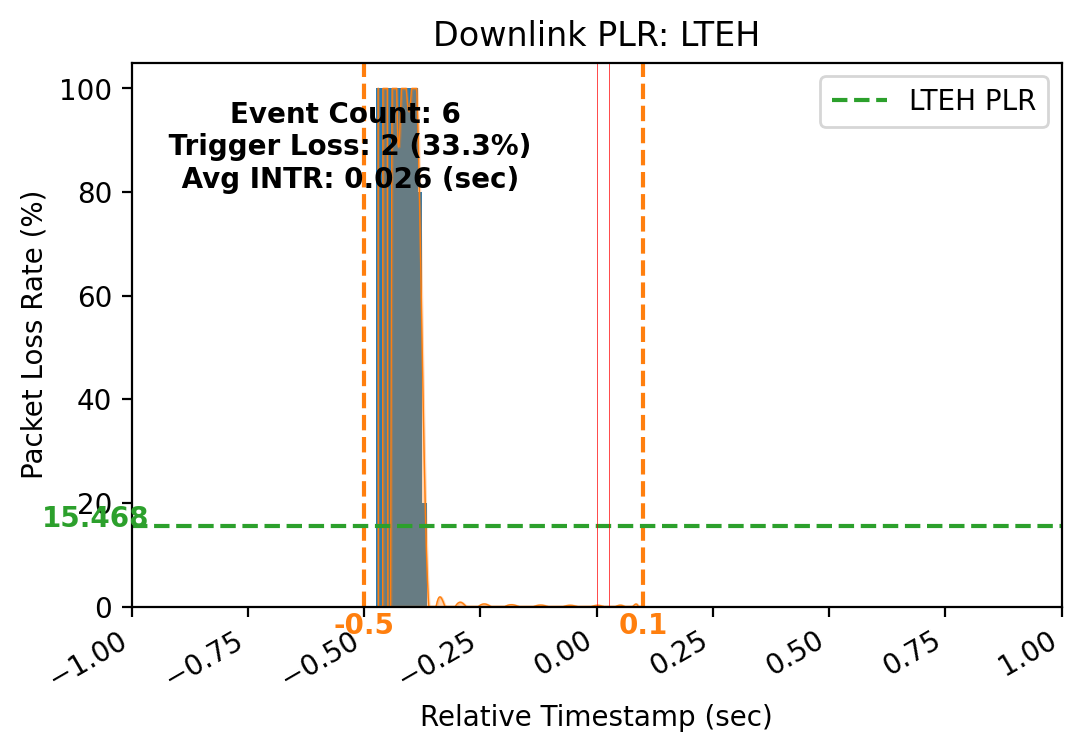

ENBH
Number of Event: 11
Number of Triggered: 1
Average Duration: 0.02198363636363637 seconds
[(-0.5, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.1) 24.303


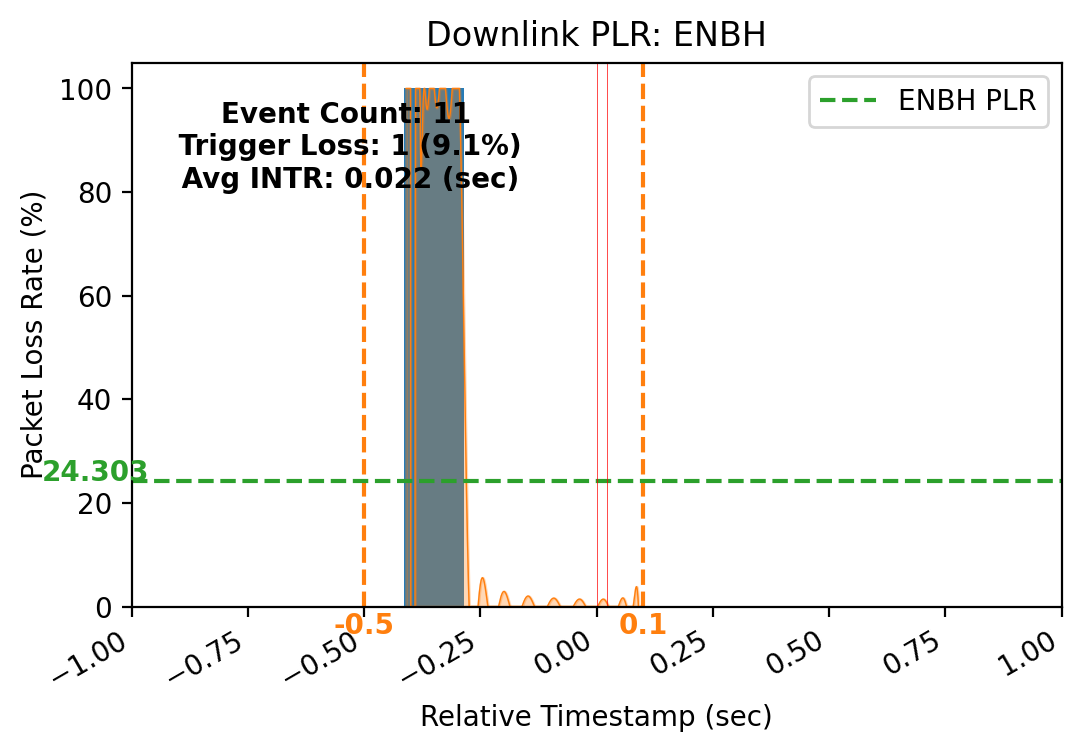

MCGH
Number of Event: 44
Number of Triggered: 14
Average Duration: 0.018170431818181818 seconds
[(-1.2, 0.7)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.2, 0.7) 9.682


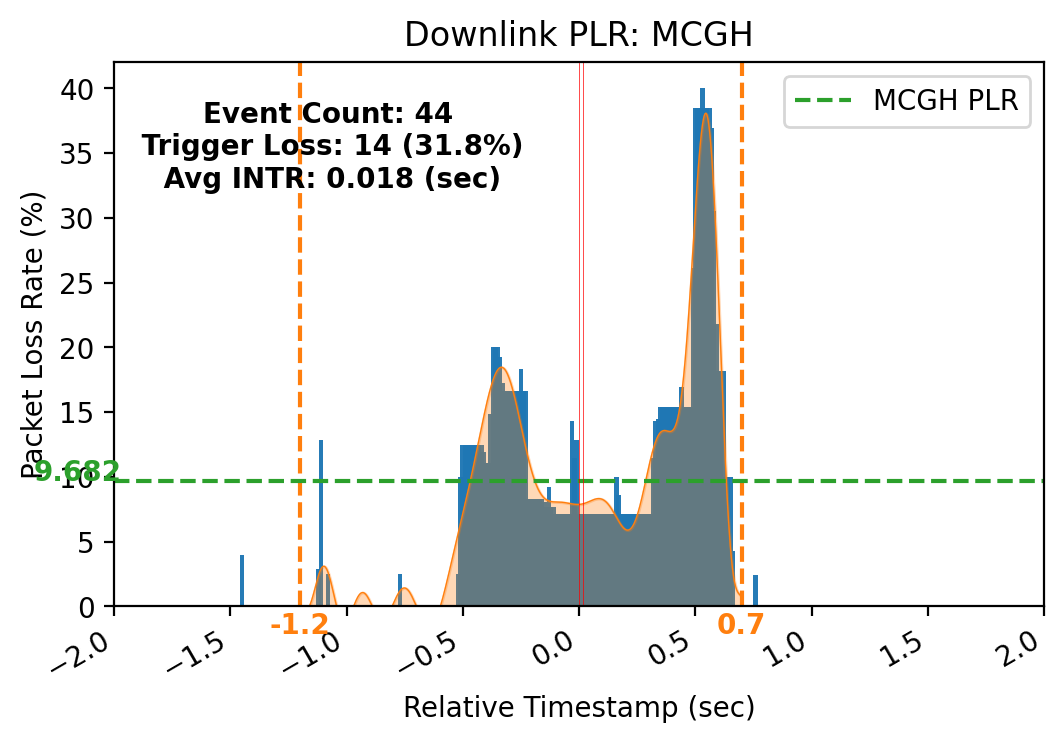

MNBH
Number of Event: 107
Number of Triggered: 36
Average Duration: 0.01884654205607476 seconds
[(-1.2, 4.5)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.2, 4.5) 9.184


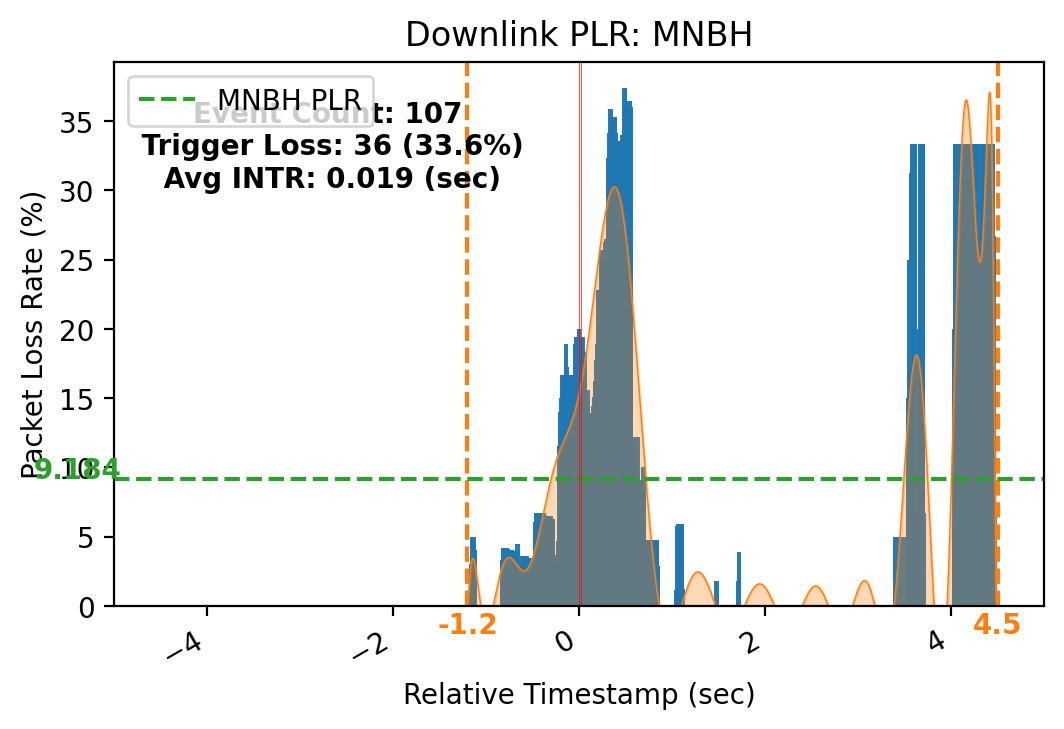

SCGA
Number of Event: 11
Number of Triggered: 1
Average Duration: 0.03806263636363636 seconds
[(-5.0, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-5.0, 0.1) 59.027


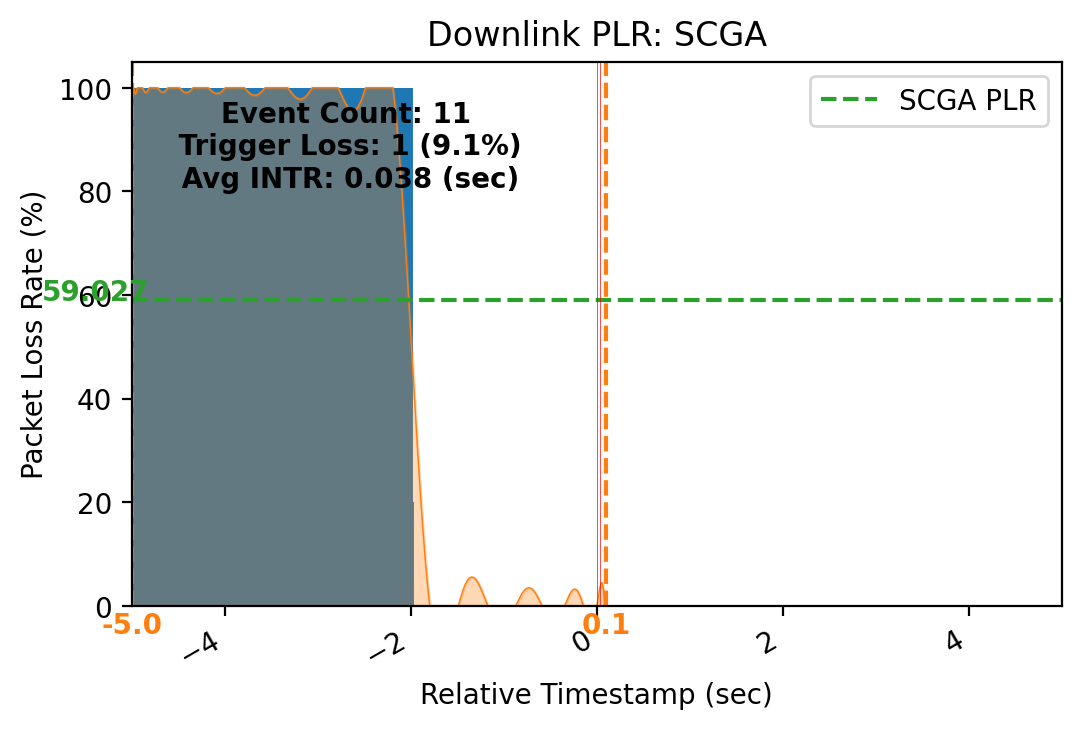

SCGM
Number of Event: 113
Number of Triggered: 49
Average Duration: 0.018403513274336286 seconds
[(-4.9, 2.2)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.9, 2.2) 2.453


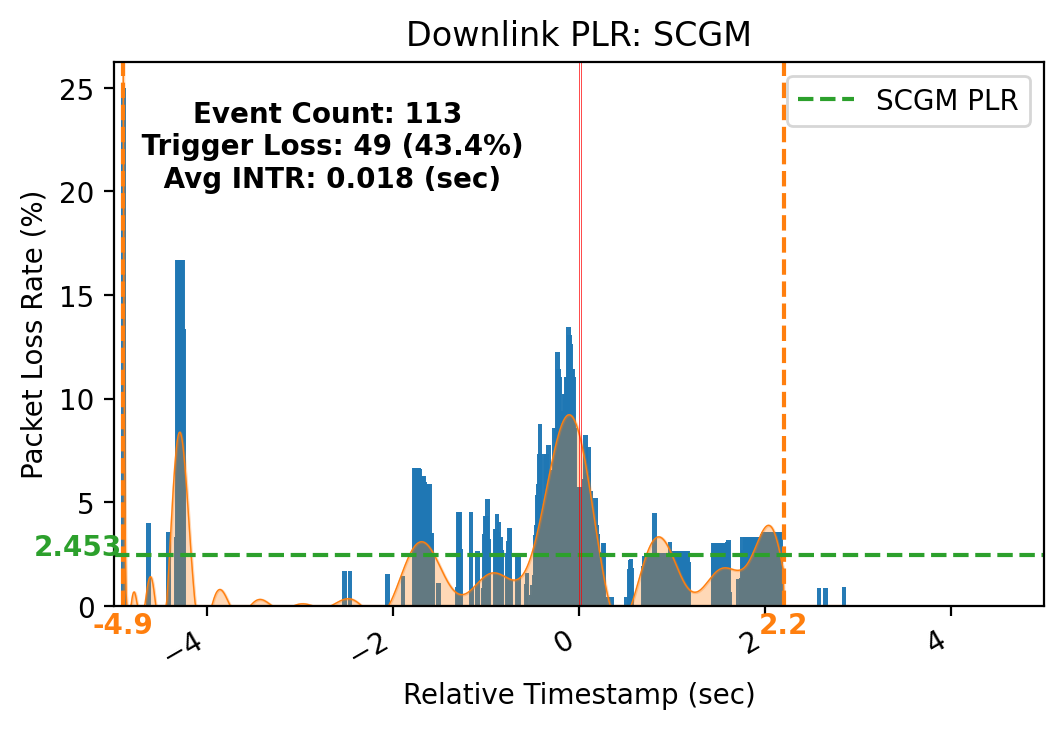

SCGR-II
Number of Event: 3
Number of Triggered: 1
Average Duration: 0.04248266666666667 seconds
[(-0.1, 0.2)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 0.2) 0.84


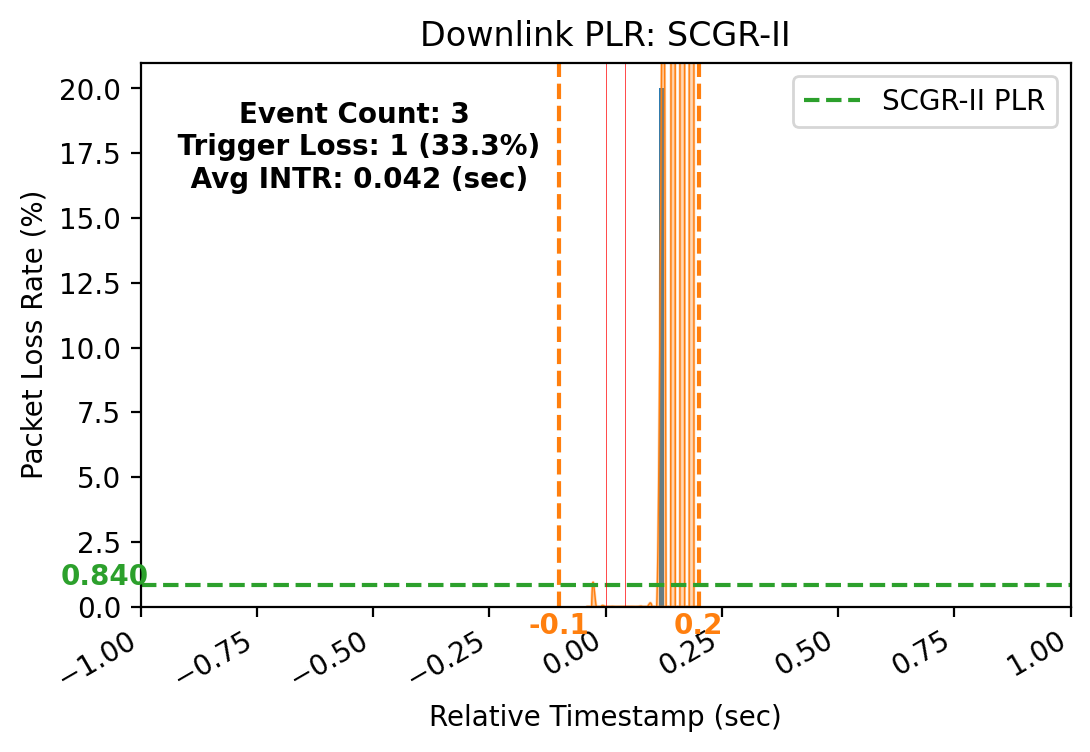

SCGC-I
Number of Event: 6
Number of Triggered: 1
Average Duration: 0.38637916666666666 seconds
[(-0.2, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.2, 0.1) 30.405


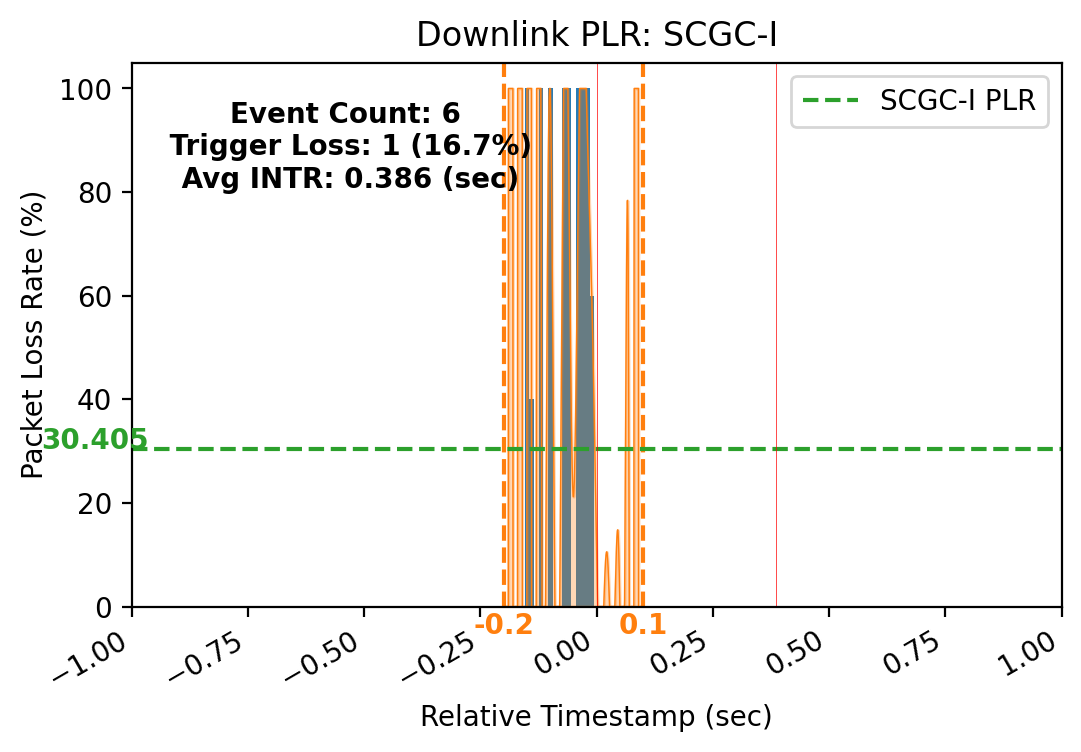

SCGC-II
Number of Event: 6
Number of Triggered: 2
Average Duration: 0.3367286666666667 seconds
[(-4.6, 0.4)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.6, 0.4) 0.217


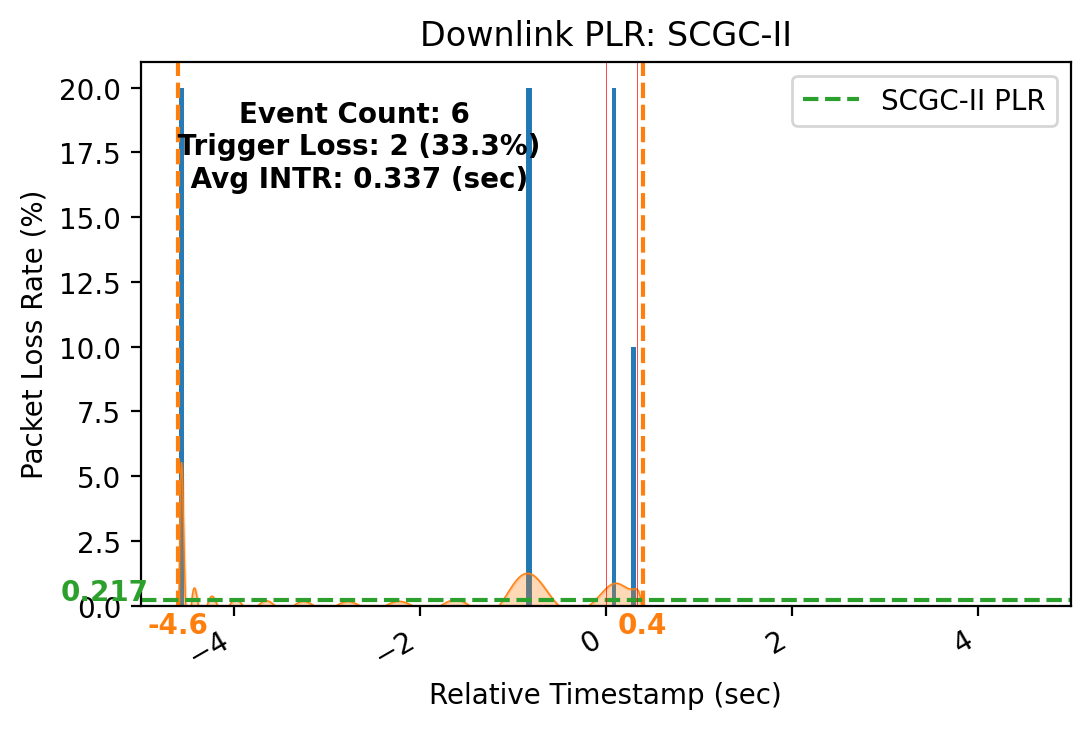

MCGF
Number of Event: 30
Number of Triggered: 30
Average Duration: 0.09295756666666666 seconds
[(-2.0, 6.6)]
Downlink Stable PLR: 0.0
Downlink PLR (-2.0, 6.6) 35.845


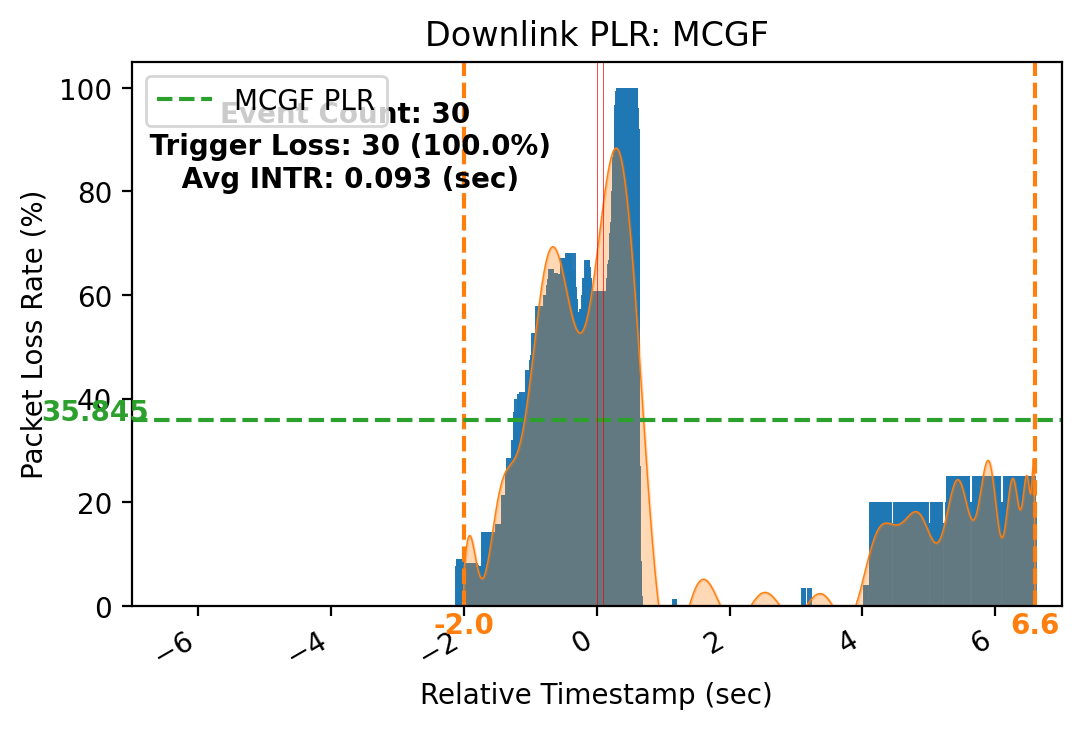

SCGF
Number of Event: 9
Number of Triggered: 2
Average Duration: 0.09646266666666665 seconds
[(-6.4, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-6.4, 0.1) 4.259


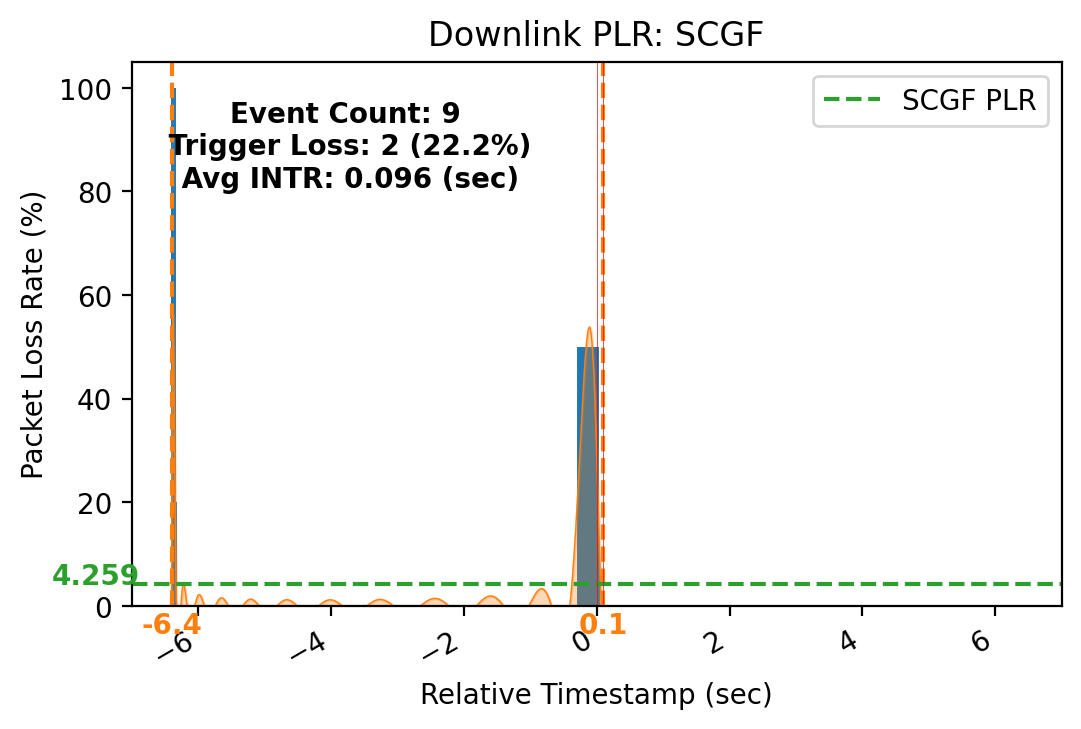

stable
Number of Event: 1563
Number of Triggered: 118
Average Duration: 1.0 seconds
Downlink Stable PLR: 0.0
Downlink PLR (-0.5, 0.5) 82.692


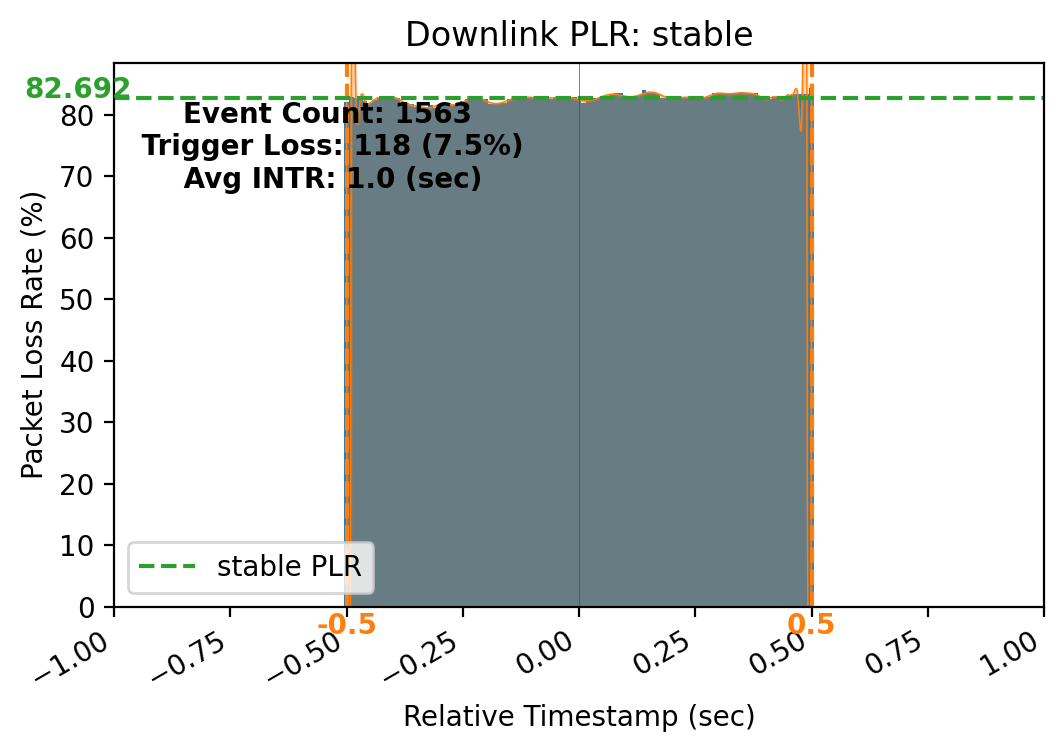

{'dl_lost': {'LTEH': (-0.5, 0.1),
             'ENBH': (-0.5, 0.1),
             'MCGH': (-1.2, 0.7),
             'MNBH': (-1.2, 4.5),
             'SCGA': (-5.0, 0.1),
             'SCGM': (-4.9, 2.2),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-0.1, 0.2),
             'SCGC-I': (-0.2, 0.1),
             'SCGC-II': (-4.6, 0.4),
             'MCGF': (-2.0, 6.6),
             'NASR': (-10.0, 10.0),
             'SCGF': (-6.4, 0.1),
             'stable': (-0.5, 0.5)}}


In [27]:
# # de-comment while not running the first time
# D = HOType_D.copy()
# E = HOType_E.copy()
# scope = { mets: {
#     tag: Category_scope[mets][category] for tag, category in lookup.items()
# } for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# # *******************************************************************************************
D = HOType_D.copy()
E = HOType_E.copy()
scope = Initial_scope.copy()
# metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']
metrics=['dl_lost']

coef_tpl = pd.DataFrame(columns=['count', 'triggered', 'PLR/ELR', 'lower_bd', 'upper_bd', 'intr', *list(range(71))])
for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']:
    coef_tpl.loc[tag] = [0, 0, 0, -5, 5, 0, *np.zeros(71)]
for tag in ['MCGF', 'NASR', 'SCGF']:
    coef_tpl.loc[tag] = [0, 0, 0, -10, 10, 0, *np.zeros(71)]
coef_tpl.loc['stable'] = ['-', '-', 0, '-', '-', '-', *np.zeros(71)]
    
coef_df = {mets: coef_tpl.copy() for mets in metrics}

# coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
# coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

dist_df = {mets: {tag: pd.DataFrame(columns=['cat_id', 'tx_count', 'lost', 'PLR']) for tag in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGA', 'SCGM', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'MCGF', 'NASR', 'SCGF', 'stable']} for mets in metrics}

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in metrics }

for tag in [*scope[list(scope.keys())[0]].keys(), 'stable']:
    if len(D[list(D.keys())[0]][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
    
    for mm in metrics:
        mode = mm[:2]
        mets = mm[-4:]
        
        if mets == 'lost':
            stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_PLR
        elif mets == 'excl':
            stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
            coef_df[f'{mode}_{mets}'].loc['stable', 'PLR/ELR'] = stable_ELR
            
        table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
        
        print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
        print('Number of Triggered:', sum(D[f'{mode}_{mets}'][tag]['triggered']))
        print('Average Duration:', intr, 'seconds')
        
        if tag == 'stable':
            min_scope = (-0.5, 0.5)
        else:
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
        
        if min_scope != 0:
            new_scope[f'{mode}_{mets}'][tag] = min_scope
        
        # def plot_polynomial(scope, mode, mets, ):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # # *********************************************************
        # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
        # new_scope[f'{mode}_{mets}'][tag] = min_scope
        # # *********************************************************
        
        if tag == 'stable':
            left = -0.5; right = 0.5
        else:
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
        bound = math.ceil(max(abs(right), abs(left)))
        left = -bound; right = bound
        ax.set_xlim(left, right)
        
        # width = 0.015 * (right - left)
        width = 0.005 * (right - left)
        if mets == 'lost':
            ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
        elif mets == 'excl':
            ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
            
        ax.set_ylim(0, max(1, ax.get_ylim()[1]))
        bottom, top = ax.get_ylim()

        if min_scope != 0:
            ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
            ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
            ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
            
            bleft = min_scope[0]
            bright = min_scope[1]
            
            x = np.asarray(table['cat_id'], dtype=np.float64)
            if mets == 'lost':
                y = np.asarray(table['PLR'], dtype=np.float64)
            elif mets == 'excl':
                y = np.asarray(table['ELR'], dtype=np.float64)
                
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                z = np.polyfit(x, y, 70)
                p = np.poly1d(z)
            xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
            
            coef = p.coefficients
            
            ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
            ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
        
        if mets == 'lost':
            # ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
            # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable PLR:', stable_PLR)
                    print('Downlink PLR', min_scope, PLR)
                elif mode == 'ul':
                    print('Uplink Stable PLR:', stable_PLR)
                    print('Uplink PLR', min_scope, PLR)
                ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        elif mets == 'excl':
            # ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
            # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
            if min_scope != 0:
                _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                if mode == 'dl':
                    print('Downlink Stable ELR:', stable_ELR)
                    print('Downlink ELR', min_scope, ELR)
                elif mode == 'ul':
                    print('Uplink Stable ELR:', stable_ELR)
                    print('Uplink ELR', min_scope, ELR)
                ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                
        count = sum(D[f'{mode}_{mets}'][tag]['count'])
        triggered = sum(D[f'{mode}_{mets}'][tag]['triggered'])
        trigger_rate = sum(D[f'{mode}_{mets}'][tag]['triggered']) / (sum(D[f'{mode}_{mets}'][tag]['count']) + 1e-9) * 100
        intr = round(intr, 3)
        ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
        ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Trigger Loss: {triggered} ({round(trigger_rate, 1)}%)\n Avg INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
        
        # ******************************************************************************************************************
        if min_scope != 0:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, PLR, bleft, bright, intr, *list(coef)]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag] = [count, trigger_rate / 100, ELR, bleft, bright, intr, *list(coef)]
            # display(table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)])
            dist_df[f'{mode}_{mets}'][tag] = table[(table['cat_id'] >= bleft) & (table['cat_id'] <= bright)].reset_index(drop=True).copy()
        else:
            if mets == 'lost':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            elif mets == 'excl':
                coef_df[f'{mode}_{mets}'].loc[tag, ['count', 'triggered', 'intr']] = [count, trigger_rate / 100, intr]
            # display(table)
            dist_df[f'{mode}_{mets}'][tag] = table.copy()
        # ******************************************************************************************************************
        
        if mode == 'dl':
            if mets == 'lost':
                ax.set_title(f'Downlink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Downlink ELR: {tag}')
        elif mode == 'ul':
            if mets == 'lost':
                ax.set_title(f'Uplink PLR: {tag}')
            elif mets == 'excl':
                ax.set_title(f'Uplink ELR: {tag}')
        
        if mets == 'lost':
            ax.set_ylabel('Packet Loss Rate (%)')
        elif mets == 'excl':
            ax.set_ylabel('Excessive Latency Rate (%)')
        ax.set_xlabel('Relative Timestamp (sec)')
        ax.legend()
        
        plt.gcf().autofmt_xdate()
        plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
# HOType_scope = new_scope.copy()

In [28]:
coef_dl_lost = coef_df['dl_lost'].copy()
dist_dl_lost = dist_df['dl_lost'].copy()

with open('./dist_dl_lost_A_one_trial.pkl', 'wb') as handle:
    pickle.dump(dist_dl_lost, handle, protocol=pickle.HIGHEST_PROTOCOL)
coef_dl_lost.to_pickle('./coef_dl_lost_A_one_trial.pkl')

In [29]:
coef_dl_lost

,count,triggered,PLR/ELR,lower_bd,upper_bd,intr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTEH,6,0.333333,15.468,-0.5,0.1,0.026,1.236647e+34,-8.329684e+32,-2.950682e+33,1.987872e+33,-6.592139e+32,1.341573e+31,1.443501e+32,-1.159346e+32,5.863787e+31,-2.033591e+31,2.938491e+30,2.320228e+30,-2.609040e+30,1.633930e+30,-7.589789e+29,2.560102e+29,-3.838383e+28,-2.734859e+28,3.199267e+28,-2.058929e+28,9.886657e+27,-3.522547e+27,6.557849e+26,2.710736e+26,-3.800757e+26,2.542253e+26,-1.230174e+26,4.273391e+25,-6.588295e+24,-4.561961e+24,5.273045e+24,-3.224387e+24,1.373440e+24,-3.479430e+23,-4.452676e+22,1.166389e+23,-8.065785e+22,3.493142e+22,-7.699363e+21,-2.421432e+21,3.602919e+21,-2.045834e+21,6.045633e+20,6.406801e+19,-1.865022e+20,1.065847e+20,-2.250249e+19,-1.201753e+19,1.222060e+19,-3.533433e+18,-1.278699e+18,1.427201e+18,-1.754716e+17,-2.960210e+17,1.328403e+17,1.321153e+17,3.358453e+16,1.693444e+15,-7.018878e+14,-1.150667e+14,1.189656e+12,1.455071e+12,6.109528e+10,-7.666758e+09,-5.128072e+08,1.808196e+07,1.505963e+06,-1.769700e+04,-1505.194701,5.723710,0.235604
ENBH,11,0.090909,24.303,-0.5,0.1,0.022,-5.409342e+39,-2.306325e+39,9.183573e+38,-8.779442e+37,-7.932143e+37,5.665779e+37,-2.199470e+37,5.069617e+36,1.654332e+35,-9.145325e+35,5.895481e+35,-2.543715e+35,7.919791e+34,-1.324497e+34,-3.856850e+33,4.942220e+33,-2.863339e+33,1.207634e+33,-3.784154e+32,6.575665e+31,1.738082e+31,-2.372927e+31,1.405228e+31,-6.000024e+30,1.877016e+30,-3.059315e+29,-1.067255e+29,1.291030e+29,-7.305632e+28,2.914208e+28,-7.750753e+27,3.278113e+26,1.130061e+27,-8.384017e+26,3.762137e+26,-1.080426e+26,6.329984e+24,1.488566e+25,-1.090485e+25,4.423721e+24,-8.804213e+23,-2.376844e+23,3.028244e+23,-1.383356e+23,2.585338e+22,1.044956e+22,-1.030890e+22,3.386751e+21,2.555490e+20,-7.366253e+20,2.552903e+20,5.456970e+19,-5.861285e+19,9.311670e+18,1.944663e+19,5.346828e+18,2.408268e+17,-1.217745e+17,-1.821528e+16,4.672863e+14,2.538673e+14,7.945050e+12,-1.535847e+12,-8.599320e+10,4.456687e+09,3.142487e+08,-5.976999e+06,-4.461768e+05,3203.598463,173.287091,-0.356281
MCGH,44,0.318182,9.682,-1.2,0.7,0.018,5.232625e-01,1.457256e+00,-6.832899e-01,-1.576041e+00,3.499508e+00,-3.178355e+00,-6.415439e-01,7.658282e+00,-1.523017e+01,1.817773e+01,-9.746013e+00,-1.569728e+01,5.812909e+01,-1.061584e+02,1.323779e+02,-9.352599e+01,-5.870373e+01,3.516979e+02,-7.479873e+02,1.095501e+03,-1.086074e+03,2.941804e+02,1.702244e+03,-4.920644e+03,8.654973e+03,-1.050834e+04,7.335057e+03,6.534040e+03,-3.037733e+04,6.724285e+04,-8.331274e+04,8.586064e+04,5.533598e+04,-1.647048e+05,6.410659e+05,-3.751318e+05,1.067361e+06,1.737132e+06,1.727885e+05,8.398070e+06,4.098752e+06,1.191884e+07,3.029826e+07,3.676412e+06,4.087880e+07,2.102892e+07,-1.196491e+08,-3.670969e+07,-1.885594e+08,-4.409612e+08,5.354649e+08,1.194960e+09,-3.778564e+08,-1.362256e+09,6.300298e+06,8.725973e+08,1.337186e+08,-3.414684e+08,-8.291073e+07,8.317467e+07,2.422630e+07,-1.235339e+07,-3.785895e+06,1.046663e+06,2.998578e+05,-4.186988e+04,-9.642741e+03,3.126826e+02,99.244646,1.156347,7.875502
MNBH,107,0.336449,9.184,-1.2,4.5,0.019,-2.616717e-35,2.138936e-34,3.379446e-34,-1.963785e-33,-1.420484e-32,-4.269090e-32,-1.384552e-33,7.657570e-31,5.067827e-30,2.007767e-29,4.351310e-29,-7.719933e-29,-1.406073e-27,-8.801605e-27,-3.750846e-26,-1.058190e-25,-4.844908e-26,1.754598e-24,1.434639e-23,7.424338e-23,2.785310e-22,6.301545e-22,-8.348234e-22,-1.936045e-20,-1.322895e-19,-6.222101e-19,-2.067067e-18,-3.038256e-18,1.956127e-17,2.135450e-16,1.227082e-15,4.898793e-15,1.150629e-14,-1.595558e-14,-3.627608e-13,-2.377595e-12,-9.979165e-12,-2.303910e-11,4.436133e-11,8.128571e-10,4.853887e-09,1.671620e-08,1.121409e-08,-2.854255e-07,-2.145347e-06,-7.719141e-06,-1.682133e-06,1.596041e-04,9.724505e-04,1.786545e-03,-1.214556e-02,-1.048739e-01,-9.231488e-02,1.358420e+00,1.410294e+01,-8.148928e+

# Evaluation Test

In [30]:
with open('./dist_dl_lost_A_one_trial.pkl', 'rb') as handle:
    dist_dl_lost = pickle.load(handle)
coef_dl_lost = pd.read_pickle('./coef_dl_lost_A_one_trial.pkl')

scope = {}
for tag, lower_bd, upper_bd in zip(coef_dl_lost.index[:-1], coef_dl_lost['lower_bd'].to_numpy()[:-1], coef_dl_lost['upper_bd'].to_numpy()[:-1]):
    # print(tag, lower_bd, upper_bd)
    scope[tag] = (lower_bd, upper_bd)

scope

{'LTEH': (-0.5, 0.1),
 'ENBH': (-0.5, 0.1),
 'MCGH': (-1.2, 0.7),
 'MNBH': (-1.2, 4.5),
 'SCGA': (-5.0, 0.1),
 'SCGM': (-4.9, 2.2),
 'SCGR-I': (-5.0, 5.0),
 'SCGR-II': (-0.1, 0.2),
 'SCGC-I': (-0.2, 0.1),
 'SCGC-II': (-4.6, 0.4),
 'MCGF': (-2.0, 6.6),
 'NASR': (-10.0, 10.0),
 'SCGF': (-6.4, 0.1)}

In [31]:
coef_dl_lost

,count,triggered,PLR/ELR,lower_bd,upper_bd,intr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTEH,6,0.333333,15.468,-0.5,0.1,0.026,1.236647e+34,-8.329684e+32,-2.950682e+33,1.987872e+33,-6.592139e+32,1.341573e+31,1.443501e+32,-1.159346e+32,5.863787e+31,-2.033591e+31,2.938491e+30,2.320228e+30,-2.609040e+30,1.633930e+30,-7.589789e+29,2.560102e+29,-3.838383e+28,-2.734859e+28,3.199267e+28,-2.058929e+28,9.886657e+27,-3.522547e+27,6.557849e+26,2.710736e+26,-3.800757e+26,2.542253e+26,-1.230174e+26,4.273391e+25,-6.588295e+24,-4.561961e+24,5.273045e+24,-3.224387e+24,1.373440e+24,-3.479430e+23,-4.452676e+22,1.166389e+23,-8.065785e+22,3.493142e+22,-7.699363e+21,-2.421432e+21,3.602919e+21,-2.045834e+21,6.045633e+20,6.406801e+19,-1.865022e+20,1.065847e+20,-2.250249e+19,-1.201753e+19,1.222060e+19,-3.533433e+18,-1.278699e+18,1.427201e+18,-1.754716e+17,-2.960210e+17,1.328403e+17,1.321153e+17,3.358453e+16,1.693444e+15,-7.018878e+14,-1.150667e+14,1.189656e+12,1.455071e+12,6.109528e+10,-7.666758e+09,-5.128072e+08,1.808196e+07,1.505963e+06,-1.769700e+04,-1505.194701,5.723710,0.235604
ENBH,11,0.090909,24.303,-0.5,0.1,0.022,-5.409342e+39,-2.306325e+39,9.183573e+38,-8.779442e+37,-7.932143e+37,5.665779e+37,-2.199470e+37,5.069617e+36,1.654332e+35,-9.145325e+35,5.895481e+35,-2.543715e+35,7.919791e+34,-1.324497e+34,-3.856850e+33,4.942220e+33,-2.863339e+33,1.207634e+33,-3.784154e+32,6.575665e+31,1.738082e+31,-2.372927e+31,1.405228e+31,-6.000024e+30,1.877016e+30,-3.059315e+29,-1.067255e+29,1.291030e+29,-7.305632e+28,2.914208e+28,-7.750753e+27,3.278113e+26,1.130061e+27,-8.384017e+26,3.762137e+26,-1.080426e+26,6.329984e+24,1.488566e+25,-1.090485e+25,4.423721e+24,-8.804213e+23,-2.376844e+23,3.028244e+23,-1.383356e+23,2.585338e+22,1.044956e+22,-1.030890e+22,3.386751e+21,2.555490e+20,-7.366253e+20,2.552903e+20,5.456970e+19,-5.861285e+19,9.311670e+18,1.944663e+19,5.346828e+18,2.408268e+17,-1.217745e+17,-1.821528e+16,4.672863e+14,2.538673e+14,7.945050e+12,-1.535847e+12,-8.599320e+10,4.456687e+09,3.142487e+08,-5.976999e+06,-4.461768e+05,3203.598463,173.287091,-0.356281
MCGH,44,0.318182,9.682,-1.2,0.7,0.018,5.232625e-01,1.457256e+00,-6.832899e-01,-1.576041e+00,3.499508e+00,-3.178355e+00,-6.415439e-01,7.658282e+00,-1.523017e+01,1.817773e+01,-9.746013e+00,-1.569728e+01,5.812909e+01,-1.061584e+02,1.323779e+02,-9.352599e+01,-5.870373e+01,3.516979e+02,-7.479873e+02,1.095501e+03,-1.086074e+03,2.941804e+02,1.702244e+03,-4.920644e+03,8.654973e+03,-1.050834e+04,7.335057e+03,6.534040e+03,-3.037733e+04,6.724285e+04,-8.331274e+04,8.586064e+04,5.533598e+04,-1.647048e+05,6.410659e+05,-3.751318e+05,1.067361e+06,1.737132e+06,1.727885e+05,8.398070e+06,4.098752e+06,1.191884e+07,3.029826e+07,3.676412e+06,4.087880e+07,2.102892e+07,-1.196491e+08,-3.670969e+07,-1.885594e+08,-4.409612e+08,5.354649e+08,1.194960e+09,-3.778564e+08,-1.362256e+09,6.300298e+06,8.725973e+08,1.337186e+08,-3.414684e+08,-8.291073e+07,8.317467e+07,2.422630e+07,-1.235339e+07,-3.785895e+06,1.046663e+06,2.998578e+05,-4.186988e+04,-9.642741e+03,3.126826e+02,99.244646,1.156347,7.875502
MNBH,107,0.336449,9.184,-1.2,4.5,0.019,-2.616717e-35,2.138936e-34,3.379446e-34,-1.963785e-33,-1.420484e-32,-4.269090e-32,-1.384552e-33,7.657570e-31,5.067827e-30,2.007767e-29,4.351310e-29,-7.719933e-29,-1.406073e-27,-8.801605e-27,-3.750846e-26,-1.058190e-25,-4.844908e-26,1.754598e-24,1.434639e-23,7.424338e-23,2.785310e-22,6.301545e-22,-8.348234e-22,-1.936045e-20,-1.322895e-19,-6.222101e-19,-2.067067e-18,-3.038256e-18,1.956127e-17,2.135450e-16,1.227082e-15,4.898793e-15,1.150629e-14,-1.595558e-14,-3.627608e-13,-2.377595e-12,-9.979165e-12,-2.303910e-11,4.436133e-11,8.128571e-10,4.853887e-09,1.671620e-08,1.121409e-08,-2.854255e-07,-2.145347e-06,-7.719141e-06,-1.682133e-06,1.596041e-04,9.724505e-04,1.786545e-03,-1.214556e-02,-1.048739e-01,-9.231488e-02,1.358420e+00,1.410294e+01,-8.148928e+

## Predict A-1

In [32]:
dates = data_loader(query_dates=True)

sel_dates = [s for s in dates if s >= '2023-09-12']
exc_dates = []
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
sel_routes = ['A']
exc_routes = []

filepaths = data_loader(mode='sr', sel_dates=sel_dates, exc_exps=exc_exps, sel_routes=sel_routes)
print('============================')
# pprint(filepaths)

sampled_filepaths = filepaths[fig_index:fig_index+1]
sampled_filepaths

2023-10-26 1
{'UDP_Bandlock_9S_Phone_Airport': {'route': 'A', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '台北車站', '機場第二航廈', '13:30', '直達車'], [2, '機場第二航廈', '台北車站', '14:25', '直達車']], 'stations': ['台北車站', '三重', '新北產業園區', '新莊副都心', '泰山', '泰山貴和', '體育大學', '長庚醫院', '林口', '山鼻', '坑口', '機場第一航廈', '機場第二航廈'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-11-01 1
{'UDP_Bandlock_9S_Phone_Airport': {'route': 'A', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '台北車站', '機場第二航廈', '14:52', '普通車'], [2, '機場第二航廈', '台北車站', '16:04', '普通車']], 'stations': ['台北車站', '三重', '新北產業園區', '新莊副都心',

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv']]

In [33]:
sampled_filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv']]

In [34]:
LOSS_GT = []
LOSS_EV = []
LOSS_STD = []

N = 1
for j, s in enumerate(sampled_filepaths):
    print(f'{j+1}/{len(sampled_filepaths)}', s[0])
    ho_df = pd.read_csv(s[0], parse_dates=['start', 'end'])
    
    if ho_df.empty:
        continue
        
    dl_df = pd.read_csv(s[1], parse_dates=['Timestamp'])[['seq', 'lost', 'excl', 'Timestamp']]
    dl_df = data_aligner(dl_df, ho_df)
    
    loss_rate_list = []
    for iter_round in tqdm(range(N), ncols=1000):
        answer = pd.DataFrame()
        
        df_now = None
        df_remaining = dl_df.copy()
        df_ho = ho_df.copy()
        display(df_remaining)
        for i, row in df_ho.iterrows():
            # print('hello')
            prior_row = df_ho.iloc[i-1] if i != 0 else None
            post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
            
            # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
            if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
                print('Overlapping event occurs!!')
                print(i, row['start'], row['end'], row['type'], row['cause'])
                print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = df_ho.iloc[i-2] if i > 1 else None
            
            # Basic information
            tag = row['type']  # specific column name
            start, end = row['start'], row['end']  # handover start/end time
            intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
            
            triggered_p = coef_dl_lost.loc[tag, 'triggered']
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                if pd.notna(prior_row['end']):
                    left = prior_row['end'] + (start - prior_row['end']) / 2
                else:
                    left = prior_row['start'] + (start - prior_row['start']) / 2
            else:
                left = pd.Timestamp.min
            if post_row is not None:
                if pd.notna(end):
                    right = end + (post_row['start'] - end) / 2
                else:
                    right = start + (post_row['start'] - start) / 2
            else:
                right = pd.Timestamp.max

            # Centered at start timestamp of each handover event
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
            
            df_now = df_remaining[df_remaining['Timestamp'] < intv.upper]
            df_remaining = df_remaining[df_remaining['Timestamp'] >= intv.upper]
            
            plr_mapping = dist_dl_lost[tag].copy()
            # print(plr_mapping)
            
            # print(df_now)
            # print(df_remaining)
            
            df_now[f'rel_time'] = (df_now['Timestamp'] - start).dt.total_seconds()
            df_now[f'cat_id'] = ((df_now[f'rel_time'] + 0.005) // 0.01) * 0.01
            # print(df_now)
            
            # display(plr_mapping)
            if plr_mapping.empty:
                tmp = df_now.copy().rename(columns={'lost': 'lost_x'})
            else:
                tmp = pd.merge(df_now, plr_mapping, on='cat_id', how='left')
                tmp['PLR'] = tmp['PLR'].fillna(0)
                
                if not generate_random_boolean(triggered_p):
                    tmp['PLR'] = 0
            # display(tmp)
            
            # print(tmp)
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)

        answer = pd.concat([answer, df_remaining], axis=0)
        display(answer)
        
        # Consider stable duration
        try:
            df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})
            answer = answer[answer['tx_count'].notnull()].copy()
        except:
            df = answer.copy()
            answer = pd.DataFrame()

        df['Timestamp_sec'] = df['Timestamp'].dt.floor('S')
        df['rel_time'] = (df['Timestamp'] - df['Timestamp_sec']).dt.total_seconds() - 0.5
        df['cat_id'] = ((df['rel_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = dist_dl_lost['stable'].copy()
        df = pd.merge(df, plr_mapping, on='cat_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = df[~df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = coef_dl_lost.loc['stable', 'triggered']
        random_bool_array = [generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        df = pd.merge(df, trig_p_mapping, on='Timestamp_sec', how='left')
        df['PLR'] = df['PLR_trig'] * df['trigger']

        del df['Timestamp_sec'], df['PLR_trig'], df['trigger']

        # display(answer)
        
        answer = pd.concat([answer, df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(generate_random_boolean)
        
        display(answer)

        # print(len(dl_df))
        # print(len(answer))

        # print(dl_df['lost'].mean() * 100)
        # print(answer['Y'].mean() * 100)
        # print(answer['PLR'].mean() * 100)

        loss_rate_list.append(answer['Y'].mean() * 100)

    gt_value = dl_df['lost'].mean() * 100
    mean_value = np.mean(loss_rate_list)
    std_deviation = np.std(loss_rate_list)

    print()
    print("Mean:", mean_value)
    print("Standard Deviation:", std_deviation)
    print("Ground Truth:", gt_value)
    
    LOSS_GT.append(gt_value)
    LOSS_EV.append(mean_value)
    LOSS_STD.append(std_deviation)
    
    print('****************************************************************')
    print()

1/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv


2023-11-02 17:56:02.787022 2023-11-02 18:35:25.239424


  0%|                                                                                                         …

,seq,lost,excl,Timestamp
55792,58293,False,False,2023-11-02 17:56:02.788724
55793,58294,False,False,2023-11-02 17:56:02.790724
55794,58295,False,False,2023-11-02 17:56:02.792724
55795,58296,False,False,2023-11-02 17:56:02.794724
55796,58297,False,False,2023-11-02 17:56:02.796725
...,...,...,...,...
1212392,1214893,False,False,2023-11-02 18:34:36.096820
1212393,1214894,False,False,2023-11-02 18:34:36.098820
1212394,1214895,False,False,2023-11-02 18:34:36.100820
1212395,1214896,False,False,2023-11-02 18:34:36.102820


Overlapping event occurs!!
109 2023-11-02 18:12:32.165880 2023-11-02 18:12:32.635233 MCGH nan
110 2023-11-02 18:12:32.460537 2023-11-02 18:12:32.548924 MCGF handoverFailure (1)
Overlapping event occurs!!
158 2023-11-02 18:18:45.069357 2023-11-02 18:18:45.966701 MCGH nan
159 2023-11-02 18:18:45.827525 2023-11-02 18:18:45.914665 MCGF handoverFailure (1)


,seq,lost_x,excl,Timestamp,rel_time,cat_id,tx_count,lost_y,PLR,lost
0,58293,False,False,2023-11-02 17:56:02.788724,-9.998298,-10.00,<NA>,<NA>,0.0,NaN
1,58294,False,False,2023-11-02 17:56:02.790724,-9.996298,-10.00,<NA>,<NA>,0.0,NaN
2,58295,False,False,2023-11-02 17:56:02.792724,-9.994298,-9.99,<NA>,<NA>,0.0,NaN
3,58296,False,False,2023-11-02 17:56:02.794724,-9.992298,-9.99,<NA>,<NA>,0.0,NaN
4,58297,False,False,2023-11-02 17:56:02.796725,-9.990297,-9.99,<NA>,<NA>,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
5682,1214893,False,False,2023-11-02 18:34:36.096820,-19.964107,-19.96,<NA>,<NA>,0.0,NaN
5683,1214894,False,False,2023-11-02 18:34:36.098820,-19.962107,-19.96,<NA>,<NA>,0.0,NaN
5684,1214895,False,False,2023-11-02 18:34:36.100820,-19.960107,-19.96,<NA>,<NA>,0.0,NaN
5685,1214896,False,False,2023-11-02 18:34:36.102820,-19.958107,-19.96,<NA>,<NA>,0.0,NaN


,seq,lost_x,excl,Timestamp,rel_time,cat_id,tx_count,lost_y,PLR,lost,Y
0,58293,False,False,2023-11-02 17:56:02.788724,0.288724,0.29,575.0,480,0.0,NaN,False
1,58294,False,False,2023-11-02 17:56:02.790724,0.290724,0.29,575.0,480,0.0,NaN,False
2,58295,False,False,2023-11-02 17:56:02.792724,0.292724,0.29,575.0,480,0.0,NaN,False
3,58296,False,False,2023-11-02 17:56:02.794724,0.294724,0.29,575.0,480,0.0,NaN,False
4,58297,False,False,2023-11-02 17:56:02.796725,0.296725,0.30,575.0,480,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
1156600,1214893,False,False,2023-11-02 18:34:36.096820,-0.403180,-0.40,580.0,480,0.0,NaN,False
1156601,1214894,False,False,2023-11-02 18:34:36.098820,-0.401180,-0.40,580.0,480,0.0,NaN,False
1156602,1214895,False,False,2023-11-02 18:34:36.100820,-0.399180,-0.40,580.0,480,0.0,NaN,False
1156603,1214896,False,False,2023-11-02 18:34:36.102820,-0.397180,-0.40,580.0,480,0.0,NaN,False



Mean: 5.850311904236969
Standard Deviation: 0.0
Ground Truth: 6.418613096087256
****************************************************************



In [35]:
# LOSS_GT = LOSS_GT_A1.copy()
# LOSS_EV = LOSS_EV_A1.copy()
# LOSS_STD = LOSS_STD_A1.copy()

/Users/jackbedford/opt/anaconda3/envs/moxa/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


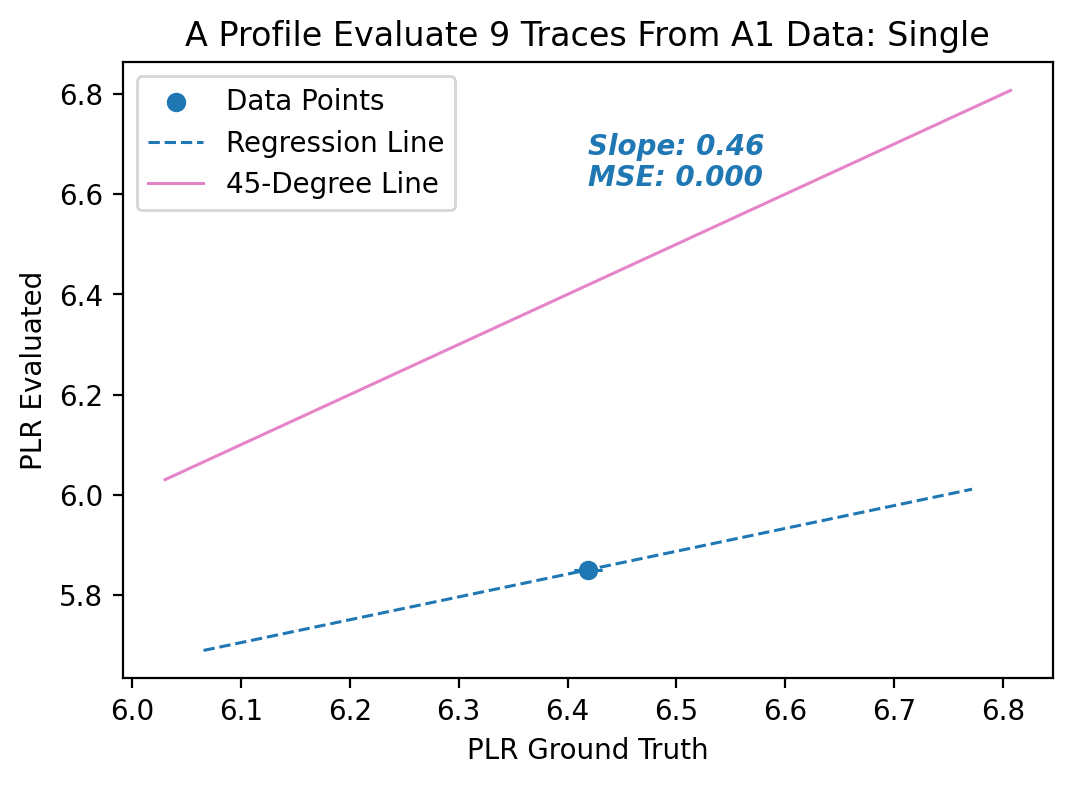

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Sample data
x = LOSS_GT.copy()
y = LOSS_EV.copy()

# Standard deviations for error bars
y_error = LOSS_STD.copy()

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot with error bars and horizontal caps
ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

# Regression line
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)
ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

# Annotate the slope of the regression line
slope_annotation = f'Slope: {coefficients[0]:.2f}'
ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# Annotate MSE From the regression line
y_pred = regression_line(x)
mse = mean_squared_error(y, y_pred)
slope_annotation = f'MSE: {mse:.3f}'
ax.annotate(slope_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

# 45-Degree Line
ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

# Set labels and title
ax.set_xlabel('PLR Ground Truth')
ax.set_ylabel('PLR Evaluated')
ax.set_title('A Profile Evaluate 9 Traces From A1 Data: Single')

# Add a legend
ax.legend()

plt.savefig(f'A_line_plot_{fig_index}.png', dpi=300)
# Show the plot
plt.show()

In [37]:
LOSS_GT_A1 = LOSS_GT.copy()
LOSS_EV_A1 = LOSS_EV.copy()
LOSS_STD_A1 = LOSS_STD.copy()

# Update fig_index

In [38]:
fig_index += 1

In [39]:
fig_index

49

In [40]:
df_ho = pd.read_csv(sampled_filepaths[0][0])
df_ho

,type,start,end,others,m_src,m_tgt,s_src,s_tgt,category,inter-eNB,inter-gNB,inter-Freq,band_cng,inter-RAT,4G_5G,cause,near_before_RLF,m_src1,m_tgt1,s_src1,s_tgt1,PCI,Cell Identity,eNB_ID,next_eNB_ID,Band ID,next_BID,DL frequency,UL frequency,DL bandwidth,UL bandwidth,TAC,MCC,MNC
0,SCGM,2023-11-02 17:56:12.787022,2023-11-02 17:56:12.806481,NaN,"(446, 3050)",NaN,NaN,"(438, 432290)",HO,True,False,False,False,False,5G,NaN,False,"(446, 3050), <NA>",NaN,NaN,"(438, 432290), <NA>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MNBH,2023-11-02 17:56:16.480372,2023-11-02 17:56:16.501582,Set up 1 SCell.,"(446, 3050)","(438, 3050)","(438, 432290)",NaN,HO,True,False,False,False,False,4G,NaN,False,"(446, 3050), <NA>","(438, 3050), 312558","(438, 432290), <NA>",NaN,NaN,NaN,NaN,312558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SCGM,2023-11-02 17:56:55.602791,2023-11-02 17:56:55.623053,NaN,"(438, 3050)",NaN,"(438, 432290)","(448, 432290)",HO,False,False,False,False,False,5G,NaN,False,"(438, 3050), 312558",NaN,"(438, 432290), 312558","(448, 432290), 312558",438.0,80014862.0,312558.0,NaN,7.0,NaN,3050.0,21050.0,20 MHz,20 MHz,13200.0,466.0,92.0
3,MNBH,2023-11-02 17:56:57.836730,2023-11-02 17:56:57.858271,Set up 1 SCell.,"(438, 3050)","(448, 3050)","(448, 432290)",NaN,HO,True,False,False,False,False,4G,NaN,False,"(438, 3050), 312558","(448, 3050), 312555","(448, 432290), 312558",NaN,438.0,80014862.0,312558.0,312555.0,7.0,NaN,3050.0,21050.0,20 MHz,20 MHz,13200.0,466.0,92.0
4,MCGH,2023-11-02 17:59:10.518823,2023-11-02 17:59:10.539630,Set up 1 SCell.,"(448, 3050)","(449, 3050)","(448, 432290)",NaN,HO,False,False,False,False,False,4G,NaN,False,"(448, 3050), 312555","(449, 3050), 312555","(448, 432290), 312555",NaN,448.0,80014104.0,312555.0,NaN,7.0,NaN,3050.0,21050.0,20 MHz,20 MHz,13200.0,466.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,SCGA,2023-11-02 18:33:21.180904,2023-11-02 18:33:21.198837,Set up 1 SCell.,"(479, 3400)",NaN,NaN,"(479, 432290)",HO,False,False,False,False,True,5G,NaN,False,"(479, 3400), 215349",NaN,NaN,"(479, 432290), 215349",479.0,55129379.0,215349.0,NaN,7.0,NaN,3400.0,21400.0,10 MHz,10 MHz,11100.0,466.0,92.0
345,SCGF,2023-11-02 18:33:35.636834,2023-11-02 18:33:35.686619,Result in gNB release.,"(479, 3400)",NaN,"(479, 432290)",NaN,RLF,False,False,False,False,False,5G,rlc-MaxNumRetx (2),False,"(479, 3400), 215349",NaN,"(479, 432290), 215349",NaN,479.0,55129379.0,215349.0,NaN,7.0,NaN,3400.0,21400.0,10 MHz,10 MHz,11100.0,466.0,92.0
346,LTEH,2023-11-02 18:34:24.631373,2023-11-02 18:34:24.649505,Set up 1 SCell.,"(479, 3400)","(432, 3400)",NaN,NaN,HO,False,False,False,False,False,4G,NaN,False,"(479, 3400), 215349","(432, 3400), 215349",NaN,NaN,479.0,55129379.0,215349.0,NaN,7.0,NaN,3400.0,21400.0,10 MHz,10 MHz,11100.0,466.0,92.0
347,SCGA,2023-11-02 18:34:56.060927,2023-11-02 18:34:56.102758,Set up 1 SCell.,"(432, 3400)",NaN,NaN,"(432, 432290)",HO,False,False,False,False,True,5G,NaN,False,"(432, 3400), 215349",NaN,NaN,"(432, 432290), 215349",432.0,55129359.0,215349.0,NaN,7.0,NaN,3400.0,21400.0,10 MHz,10 MHz,11100.0,466.0,92.0


In [41]:
sampled_filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv']]